In [1]:
# !pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
# !git checkout v0.3.0

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [2]:
import os
import numpy as np
import torch as tc
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm, trange
import pickle

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
# import transforms as T
#import cv2
from WishDataSet import WishTubeFrameDataSet, get_transform
from wish_utils import *

In [3]:
tc.__version__

'2.2.1+cu118'

In [4]:
tc.cuda.is_available(), tc.cuda.device_count()

(True, 1)

In [5]:
!nvidia-smi

Fri Apr 26 16:02:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76                 Driver Version: 550.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:00:05.0 Off |                  N/A |
| 30%   26C    P8              9W /  125W |     246MiB /   8192MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
tc.cuda.current_device(), tc.cuda.device(0), tc.cuda.get_device_name()

(0, <torch.cuda.device at 0x7f2bcc20eec0>, 'Quadro RTX 4000')

In [7]:
annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighboursIncreasedRange/Annotations/"
ds = WishTubeFrameDataSet(annotations_dir)
len(ds)

3131

In [8]:
im, tar = ds[53]
type(im), type(tar)
tar

{'boxes': tensor([[1109.,    0., 1117.,    5.],
         [ 742.,    0.,  751.,    5.],
         [ 528.,    0.,  532.,    5.]]),
 'labels': tensor([1, 1, 1]),
 'area': tensor([40., 45., 20.]),
 'iscrowd': tensor([0, 0, 0]),
 'image_id': 53}

In [9]:
im.shape

(128, 1540, 3)

In [10]:
tar

{'boxes': tensor([[1109.,    0., 1117.,    5.],
         [ 742.,    0.,  751.,    5.],
         [ 528.,    0.,  532.,    5.]]),
 'labels': tensor([1, 1, 1]),
 'area': tensor([40., 45., 20.]),
 'iscrowd': tensor([0, 0, 0]),
 'image_id': 53}

In [11]:
im[..., 0].shape

(128, 1540)

In [12]:
def plot_tube_frame_with_bbox(image, target):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cs = plt.contourf(image[..., 0])
    plt.colorbar(cs)    
    for xmin, ymin, xmax, ymax in target['boxes']:
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin),
                                 width, height,
                                 linewidth = 0.4,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        ax.add_patch(rect)
    plt.show()

### See tube frames and boxes

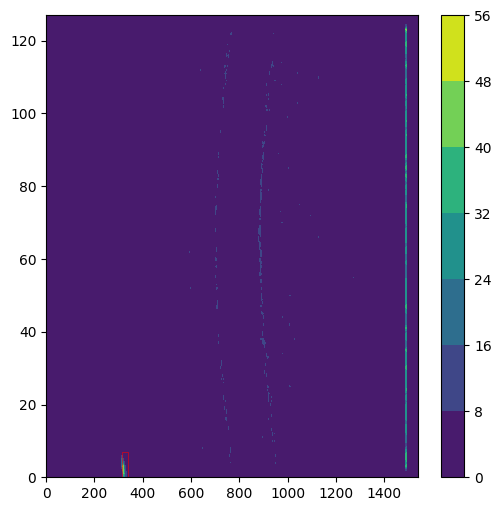

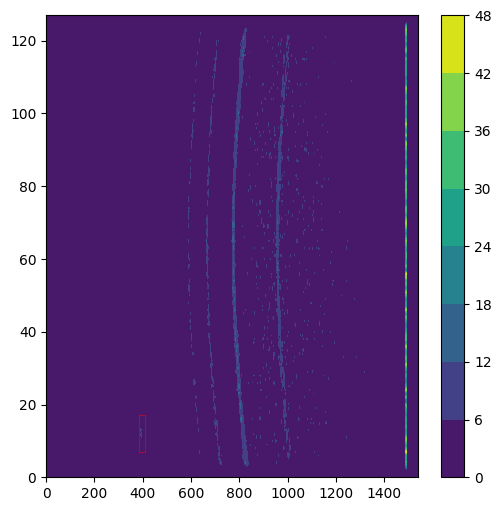

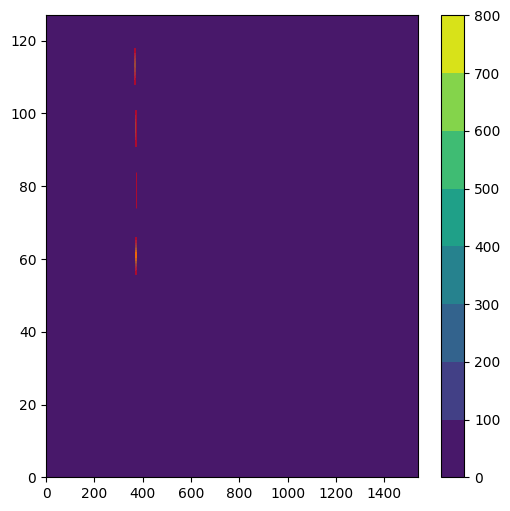

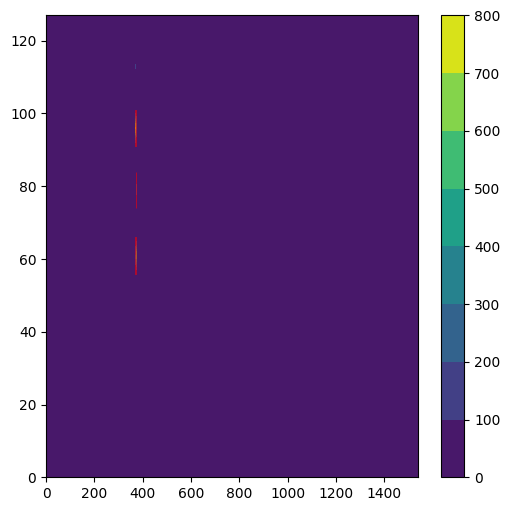

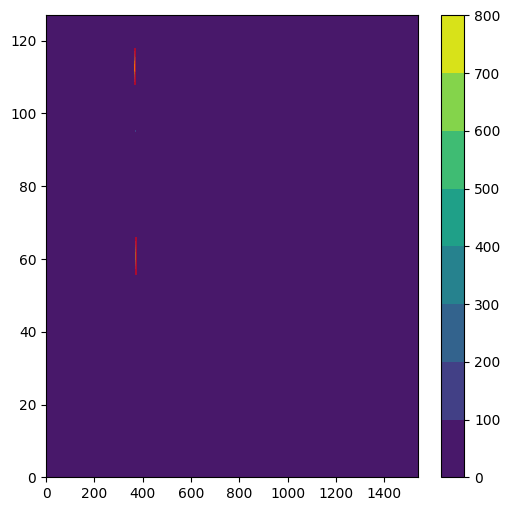

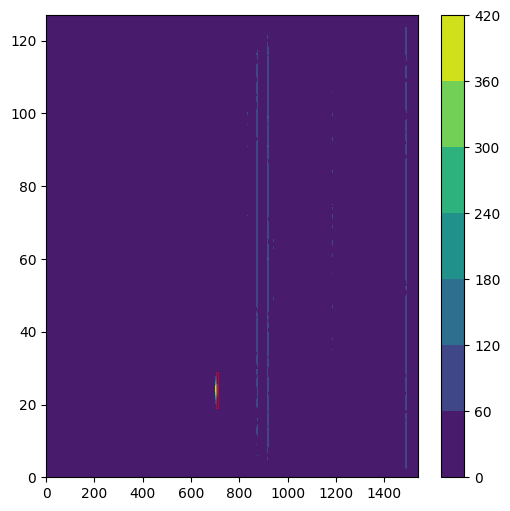

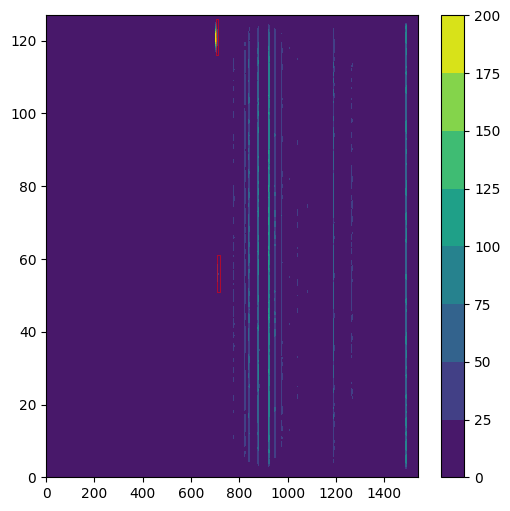

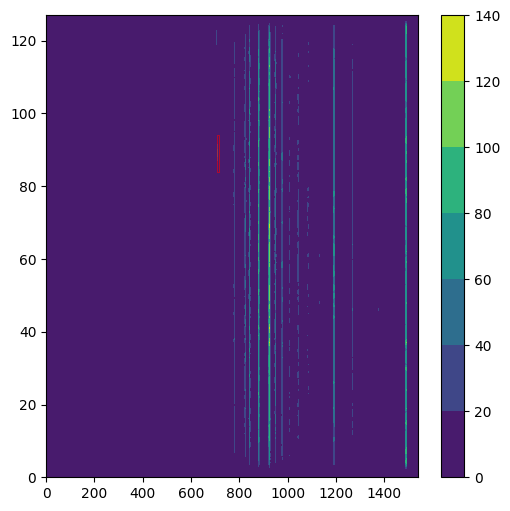

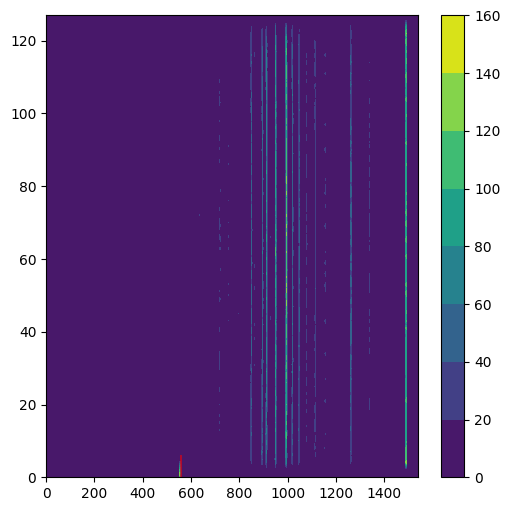

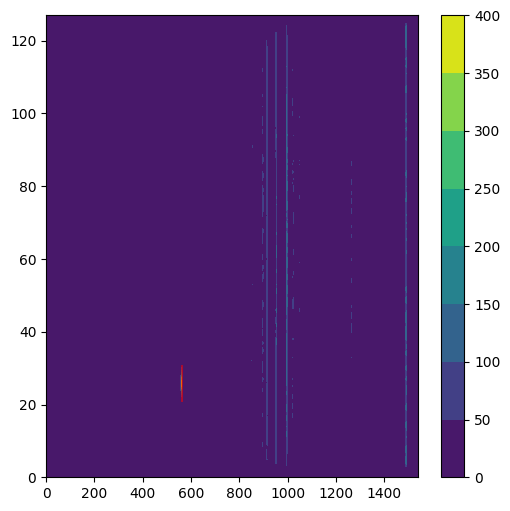

In [13]:
i=0
for (im, tar) in ds:
    plot_tube_frame_with_bbox(im, tar)
    i+=1
    if i == 10:
        break

### Calculate the stats

In [14]:
# dl = tc.utils.data.DataLoader(ds, batch_size=100, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)
# stats = get_stats(dl)
# stats

In [15]:
# stats = (np.array([1.26653515, 1.26653515, 1.26653515]), np.array([4.59509826, 4.59509826, 4.59509826]))
# stats

### Training and test data sets

In [16]:
# use our dataset and defined transformations
stats=None
dataset = WishTubeFrameDataSet(annotations_dir, transforms=get_transform(train=True))
dataset_test = WishTubeFrameDataSet(annotations_dir, transforms=get_transform(train=False))

In [17]:
# split the dataset in train and test set
tc.manual_seed(1)
indices = tc.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = tc.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = tc.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = tc.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_test = tc.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

### Model Training

In [18]:
# to train on gpu if selected.
device = tc.device('cuda') if tc.cuda.is_available() else tc.device('cpu')

num_classes = 2

model = get_object_detection_model(num_classes, pretrained=False)
freeze_to(model, False)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
p=[p.requires_grad for p in model.parameters()]
len(p)

83

In [20]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [21]:
device

device(type='cuda')

In [22]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = tc.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = tc.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=3,
                                            gamma=0.1)# to train on gpu if selected.

In [23]:
params[-5:]

[Parameter containing:
 tensor([ 0.0061, -0.0029, -0.0282,  ...,  0.0276,  0.0219, -0.0236],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0203, -0.0176, -0.0210,  ...,  0.0309,  0.0208, -0.0099],
         [ 0.0271,  0.0116,  0.0075,  ...,  0.0163,  0.0037, -0.0089]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0145, -0.0191], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0300, -0.0215,  0.0049,  ..., -0.0064, -0.0287, -0.0160],
         [ 0.0130, -0.0236, -0.0125,  ..., -0.0060, -0.0107,  0.0234],
         [-0.0258,  0.0107,  0.0310,  ...,  0.0162,  0.0190, -0.0053],
         ...,
         [-0.0235,  0.0013,  0.0235,  ...,  0.0017,  0.0061, -0.0136],
         [ 0.0146, -0.0103, -0.0229,  ...,  0.0127, -0.0079,  0.0072],
         [-0.0006, -0.0207, -0.0003,  ...,  0.0279,  0.0028,  0.0038]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0070, -0.0122, 

In [24]:
len(params)

72

In [25]:
lr_scheduler

### Training 

In [26]:
num_epochs = 20

for epoch in trange(num_epochs):
    # training for one epoch
    print(f"starting epoch {epoch}")
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

starting epoch 0
Epoch: [0]  [  0/314]  eta: 0:35:29  lr: 0.000021  loss: 17.1824 (17.1824)  loss_classifier: 2.9940 (2.9940)  loss_box_reg: 0.3372 (0.3372)  loss_objectness: 1.6336 (1.6336)  loss_rpn_box_reg: 12.2175 (12.2175)  time: 6.7809  data: 0.9374  max mem: 2126
Epoch: [0]  [ 50/314]  eta: 0:02:18  lr: 0.000819  loss: 1.3288 (3.4462)  loss_classifier: 0.0799 (0.2407)  loss_box_reg: 0.0822 (0.1143)  loss_objectness: 0.4530 (0.5939)  loss_rpn_box_reg: 0.6252 (2.4973)  time: 0.3959  data: 0.0177  max mem: 2324
Epoch: [0]  [100/314]  eta: 0:01:38  lr: 0.001617  loss: 1.0431 (2.2841)  loss_classifier: 0.0162 (0.1397)  loss_box_reg: 0.0342 (0.0886)  loss_objectness: 0.2085 (0.4330)  loss_rpn_box_reg: 0.7646 (1.6227)  time: 0.4064  data: 0.0179  max mem: 2325
Epoch: [0]  [150/314]  eta: 0:01:12  lr: 0.002415  loss: 0.6713 (1.7657)  loss_classifier: 0.0167 (0.0997)  loss_box_reg: 0.0359 (0.0724)  loss_objectness: 0.0924 (0.3312)  loss_rpn_box_reg: 0.5131 (1.2625)  time: 0.4015  data: 0

#### Save the trained model

In [27]:
model_save_path = '/mnt/ceph/home/wj1132075/Desktop/CNN_Model_Data/tube_inc_range_withneighb_fasterrcnn_resnet50_fpn.pt'

In [28]:
tc.save(model.state_dict(), model_save_path)

In [29]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with tc.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  1
real #boxes:  1


In [30]:
prediction

{'boxes': tensor([[504.8391, 105.9777, 510.3029, 116.1225]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9889], device='cuda:0')}

In [31]:
target

{'boxes': tensor([[505., 105., 510., 115.]]),
 'labels': tensor([1]),
 'area': tensor([50.]),
 'iscrowd': tensor([0]),
 'image_id': 2003}

In [32]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[504.8391, 105.9777, 510.3029, 116.1225]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9889], device='cuda:0')}

In [33]:
img.shape

torch.Size([3, 128, 1540])

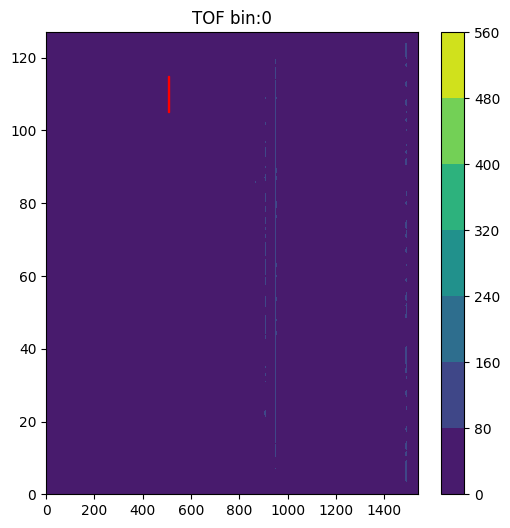

In [34]:
plot_bin(img[0,:,:], target['boxes'], 0)

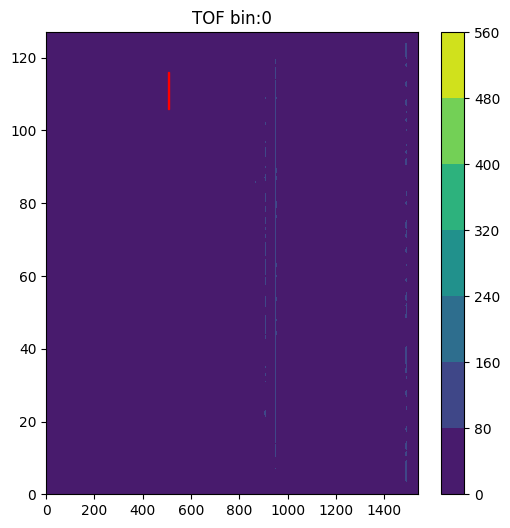

In [35]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

### Load the model from disk

In [36]:
r_model = get_object_detection_model(num_classes)
# r_model.load_state_dict(tc.load(model_save_path))
r_model.load_state_dict(tc.load(model_save_path, map_location=tc.device('cpu')))
r_model = r_model.to(device)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
img, target = dataset_test[100]
r_model.eval()
with tc.no_grad():
    prediction = r_model([img.to(device)])[0]
prediction

{'boxes': tensor([[778.9459,  31.0949, 788.1362,  41.1364],
         [781.1750,  68.2848, 791.0934,  77.6890]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9845, 0.8563], device='cuda:0')}

In [38]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[778.9459,  31.0949, 788.1362,  41.1364],
         [781.1750,  68.2848, 791.0934,  77.6890]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9845, 0.8563], device='cuda:0')}

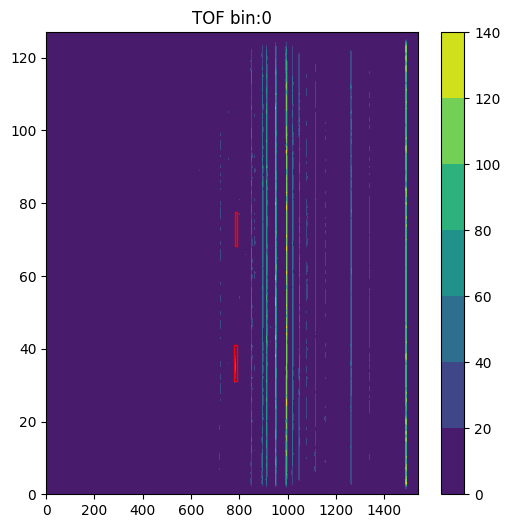

In [39]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

In [40]:
def plot_frame_detections(bin_data, real_boxes, predicted_boxes, score_threshold = 0.75):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cs = plt.contourf(bin_data)
    plt.colorbar(cs)
    for box in real_boxes.cpu():
        det_x, det_y = (box[0]+box[2])/2, (box[1]+box[3])/2
        plt.plot(det_x, det_y, marker="x", markersize=9, markeredgecolor="lime", markerfacecolor="lime")
        
    plotted_predictions = 0
    for box, score in zip(predicted_boxes['boxes'].cpu(), predicted_boxes['scores'].cpu()):
        print(f"prediction={box} score={score}")
        x_hat, y_hat = (box[0]+box[2])/2, (box[1]+box[3])/2
        if score < score_threshold:
            print(f"----->Ignoring the prediction at x={x_hat} y={y_hat} with score={score}")
            plt.plot(x_hat, y_hat, marker="x", markersize=5, markeredgecolor="white", markerfacecolor="white")
            continue
            
        print(f"Prediction coordinate x={x_hat} y={y_hat}")
        plt.plot(x_hat, y_hat, marker="x", markersize=5, markeredgecolor="red", markerfacecolor="red")
        plotted_predictions += 1

    plt.title(f"Predicted-{plotted_predictions} vs Real-{len(real_boxes)}")
    plt.show()

{'boxes': tensor([[701.7084, 100.1135, 712.2483, 110.1114],
        [706.9233,   3.0131, 716.9846,  12.9305]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9670, 0.9379], device='cuda:0')}
prediction=tensor([701.7084, 100.1135, 712.2483, 110.1114]) score=0.9670395851135254
Prediction coordinate x=706.9783935546875 y=105.11245727539062
prediction=tensor([706.9233,   3.0131, 716.9846,  12.9305]) score=0.9379408359527588
Prediction coordinate x=711.9539184570312 y=7.97183895111084


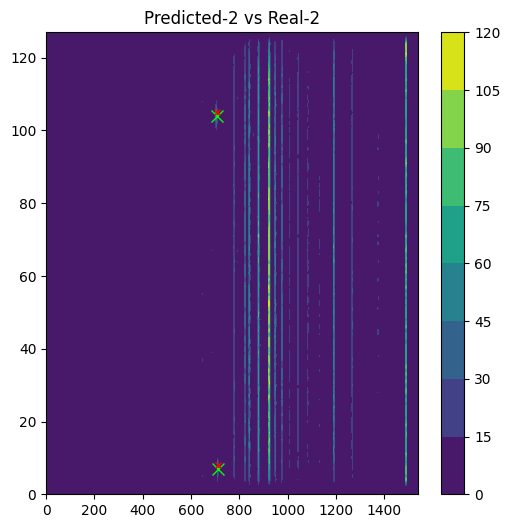

{'boxes': tensor([[485.7139,  11.1182, 490.9184,  20.9327],
        [701.3519,  20.9111, 710.1441,  31.4327]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9935, 0.8505], device='cuda:0')}
prediction=tensor([485.7139,  11.1182, 490.9184,  20.9327]) score=0.9934724569320679
Prediction coordinate x=488.3161315917969 y=16.025470733642578
prediction=tensor([701.3519,  20.9111, 710.1441,  31.4327]) score=0.8504648804664612
Prediction coordinate x=705.7479858398438 y=26.1718807220459


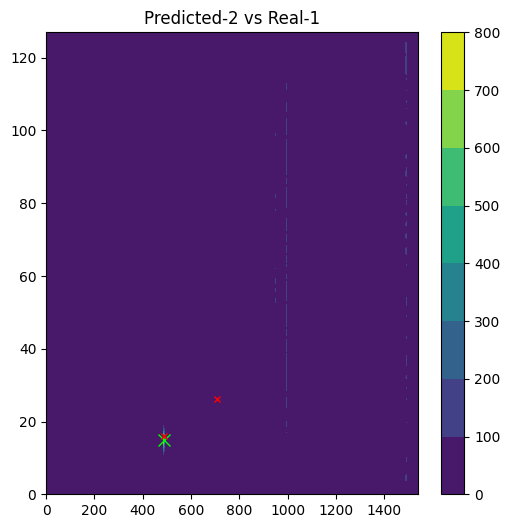

{'boxes': tensor([[635.5107,  44.0567, 642.5557,  54.0328],
        [635.1420,  72.3185, 641.5591,  82.1802]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.9269], device='cuda:0')}
prediction=tensor([635.5107,  44.0567, 642.5557,  54.0328]) score=0.9994927644729614
Prediction coordinate x=639.033203125 y=49.044761657714844
prediction=tensor([635.1420,  72.3185, 641.5591,  82.1802]) score=0.926913321018219
Prediction coordinate x=638.3505249023438 y=77.24935913085938


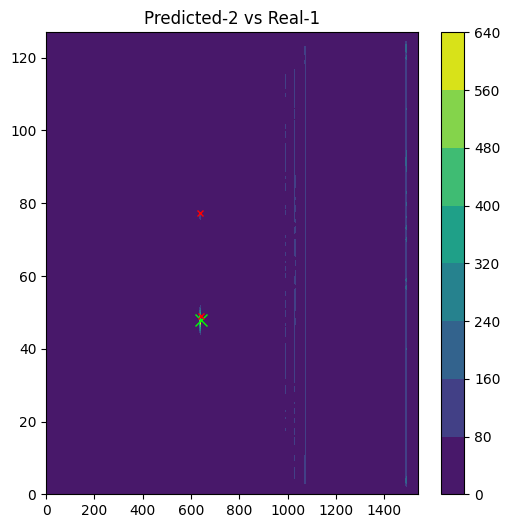

{'boxes': tensor([[6.4343e+02, 5.8227e+01, 6.4989e+02, 6.8094e+01],
        [6.4135e+02, 4.1808e-01, 6.4751e+02, 9.9705e+00],
        [6.4385e+02, 2.9079e+01, 6.5001e+02, 3.8844e+01],
        [6.4112e+02, 8.6032e+01, 6.4741e+02, 9.6058e+01],
        [6.3571e+02, 1.1494e+02, 6.4171e+02, 1.2460e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9993, 0.9960, 0.9905, 0.9292], device='cuda:0')}
prediction=tensor([643.4267,  58.2266, 649.8947,  68.0942]) score=0.9996905326843262
Prediction coordinate x=646.6607055664062 y=63.160377502441406
prediction=tensor([6.4135e+02, 4.1808e-01, 6.4751e+02, 9.9705e+00]) score=0.99925297498703
Prediction coordinate x=644.4283447265625 y=5.194291591644287
prediction=tensor([643.8458,  29.0794, 650.0095,  38.8443]) score=0.9960272312164307
Prediction coordinate x=646.9276123046875 y=33.96186828613281
prediction=tensor([641.1208,  86.0317, 647.4085,  96.0577]) score=0.9905086755752563
Prediction coordina

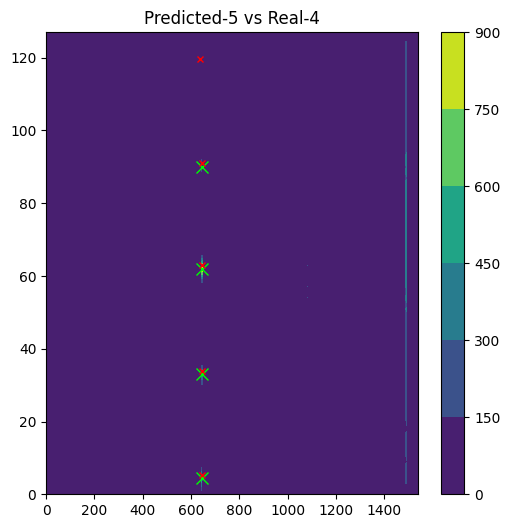

{'boxes': tensor([[619.4883,  20.8567, 626.5421,  30.9686],
        [622.7648,  49.0037, 629.1237,  58.7909]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9628, 0.8533], device='cuda:0')}
prediction=tensor([619.4883,  20.8567, 626.5421,  30.9686]) score=0.9627565741539001
Prediction coordinate x=623.0152587890625 y=25.912677764892578
prediction=tensor([622.7648,  49.0037, 629.1237,  58.7909]) score=0.8532711863517761
Prediction coordinate x=625.9442749023438 y=53.89732360839844


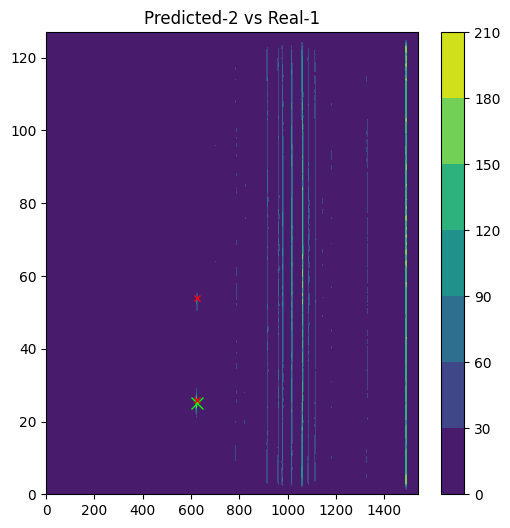

{'boxes': tensor([[504.8380, 105.9585, 510.3197, 116.1202]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9887], device='cuda:0')}
prediction=tensor([504.8380, 105.9585, 510.3197, 116.1202]) score=0.988744854927063
Prediction coordinate x=507.5788269042969 y=111.03935241699219


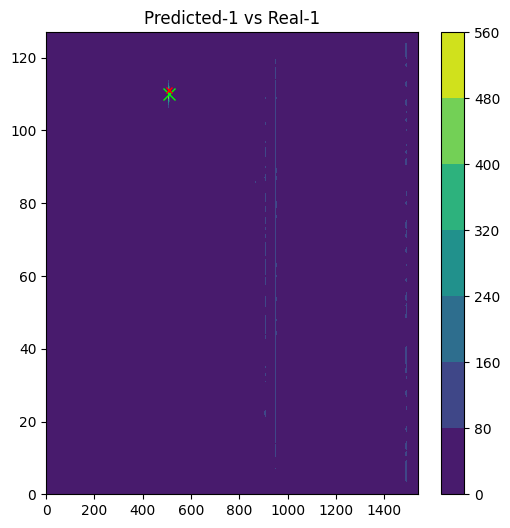

{'boxes': tensor([[707.4016,  35.1382, 717.1525,  45.1993],
        [709.8377,  67.1420, 718.7799,  76.9834],
        [702.4129,   2.1060, 712.3303,  12.3619]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.9342, 0.9257], device='cuda:0')}
prediction=tensor([707.4016,  35.1382, 717.1525,  45.1993]) score=0.9957364797592163
Prediction coordinate x=712.2770385742188 y=40.168758392333984
prediction=tensor([709.8377,  67.1420, 718.7799,  76.9834]) score=0.9342219829559326
Prediction coordinate x=714.308837890625 y=72.06272888183594
prediction=tensor([702.4129,   2.1060, 712.3303,  12.3619]) score=0.9257181286811829
Prediction coordinate x=707.37158203125 y=7.233966827392578


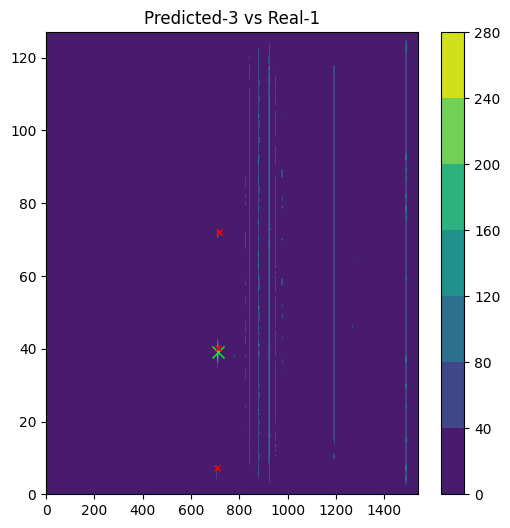

{'boxes': tensor([[747.1155,  85.0803, 755.8259,  94.8984],
        [746.0325,  50.7792, 754.2063,  60.5093]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9346, 0.7494], device='cuda:0')}
prediction=tensor([747.1155,  85.0803, 755.8259,  94.8984]) score=0.9346426129341125
Prediction coordinate x=751.470703125 y=89.98930358886719
prediction=tensor([746.0325,  50.7792, 754.2063,  60.5093]) score=0.7493776679039001
Prediction coordinate x=750.119384765625 y=55.64423370361328


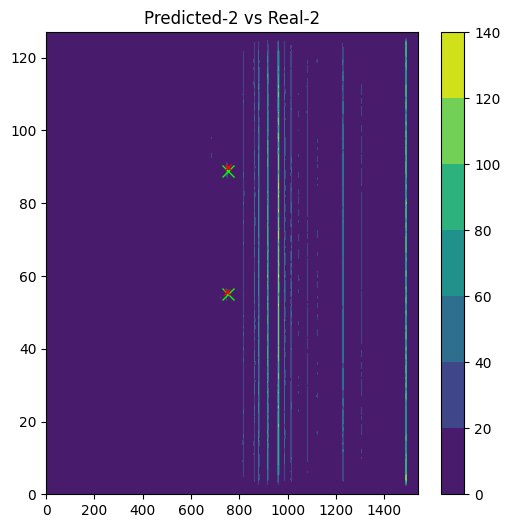

{'boxes': tensor([[585.3834, 106.7811, 595.0850, 116.6341],
        [575.3750,   4.0627, 584.6912,  14.0312],
        [370.7466,  99.0156, 375.5471, 108.7439],
        [362.7004,  13.2670, 367.2984,  22.9824],
        [358.8166,   0.0000, 363.7869,   5.9264]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.9934, 0.9896, 0.8324, 0.3409], device='cuda:0')}
prediction=tensor([585.3834, 106.7811, 595.0850, 116.6341]) score=0.9947625994682312
Prediction coordinate x=590.2341918945312 y=111.70759582519531
prediction=tensor([575.3750,   4.0627, 584.6912,  14.0312]) score=0.9934465289115906
Prediction coordinate x=580.0330810546875 y=9.046932220458984
prediction=tensor([370.7466,  99.0156, 375.5471, 108.7439]) score=0.9896103143692017
Prediction coordinate x=373.1468200683594 y=103.87977600097656
prediction=tensor([362.7004,  13.2670, 367.2984,  22.9824]) score=0.8323912620544434
Prediction coordinate x=364.9994201660156 y=18.124685287475586
p

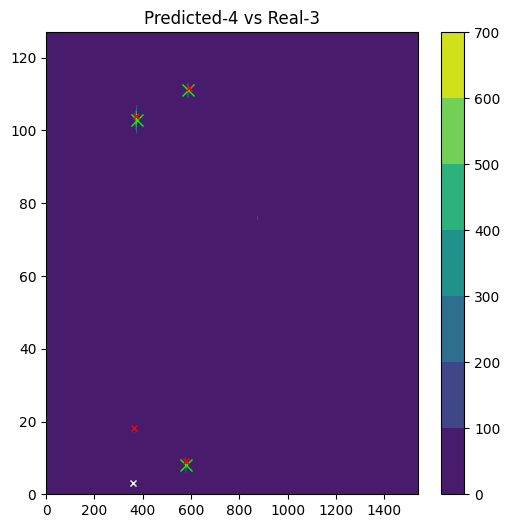

{'boxes': tensor([[492.8531, 106.0979, 498.8279, 116.1601],
        [496.2580,  83.9690, 501.3679,  93.6599],
        [496.1783,  62.6918, 501.5231,  73.0150]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.9212, 0.8191], device='cuda:0')}
prediction=tensor([492.8531, 106.0979, 498.8279, 116.1601]) score=0.9973057508468628
Prediction coordinate x=495.8404846191406 y=111.1290283203125
prediction=tensor([496.2580,  83.9690, 501.3679,  93.6599]) score=0.9211708307266235
Prediction coordinate x=498.81292724609375 y=88.814453125
prediction=tensor([496.1783,  62.6918, 501.5231,  73.0150]) score=0.8191368579864502
Prediction coordinate x=498.8507080078125 y=67.85340118408203


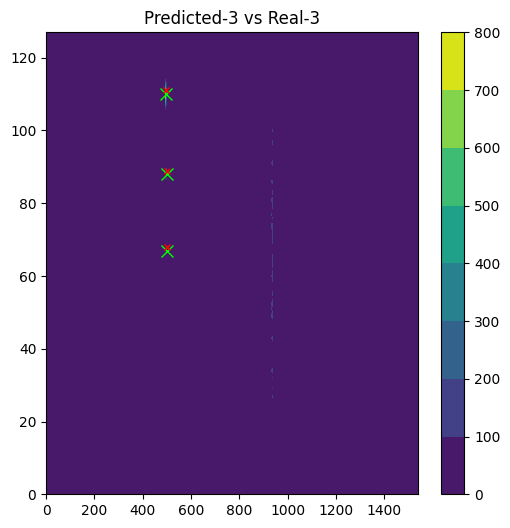

{'boxes': tensor([[503.9393, 123.1976, 508.8825, 127.9257]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}
prediction=tensor([503.9393, 123.1976, 508.8825, 127.9257]) score=0.9992784857749939
Prediction coordinate x=506.4109191894531 y=125.56166076660156


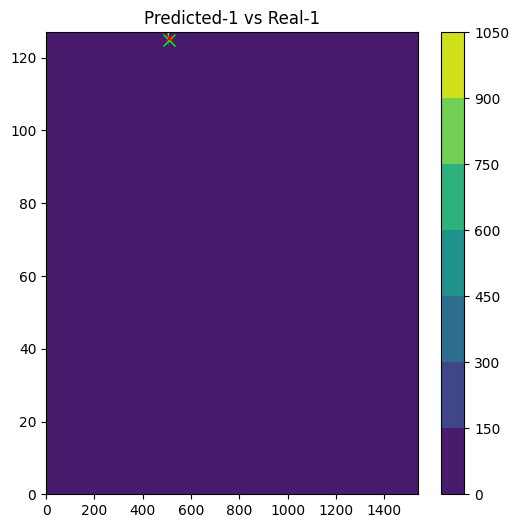

{'boxes': tensor([[7.0132e+02, 1.0502e+00, 7.1085e+02, 1.1107e+01],
        [1.0742e+03, 6.6134e+01, 1.0832e+03, 7.5979e+01],
        [7.0737e+02, 6.6013e+01, 7.1653e+02, 7.6099e+01],
        [4.8709e+02, 9.8749e-01, 4.9261e+02, 1.1154e+01],
        [4.9266e+02, 4.3945e+01, 4.9742e+02, 5.3895e+01],
        [4.9046e+02, 2.2855e+01, 4.9564e+02, 3.3032e+01],
        [4.9272e+02, 6.5870e+01, 4.9853e+02, 7.6080e+01],
        [7.0636e+02, 3.3289e+01, 7.1517e+02, 4.3408e+01],
        [1.0695e+03, 1.6487e+00, 1.0789e+03, 1.1579e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.9953, 0.9927, 0.9923, 0.9640, 0.9633, 0.8841, 0.8718, 0.7472],
       device='cuda:0')}
prediction=tensor([701.3197,   1.0502, 710.8542,  11.1068]) score=0.9988905787467957
Prediction coordinate x=706.0869140625 y=6.078453540802002
prediction=tensor([1074.1564,   66.1341, 1083.2191,   75.9789]) score=0.9953165054321289
Prediction coordinate x=1078.6877441

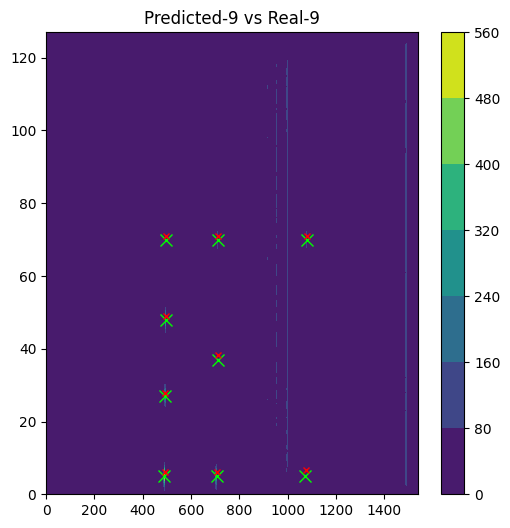

{'boxes': tensor([[641.3725,  70.9794, 648.0669,  81.0474],
        [637.7899,  98.6903, 644.3831, 108.7431]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9920, 0.6177], device='cuda:0')}
prediction=tensor([641.3725,  70.9794, 648.0669,  81.0474]) score=0.991969883441925
Prediction coordinate x=644.7197265625 y=76.01338195800781
prediction=tensor([637.7899,  98.6903, 644.3831, 108.7431]) score=0.6177228093147278
Prediction coordinate x=641.0864868164062 y=103.7166748046875


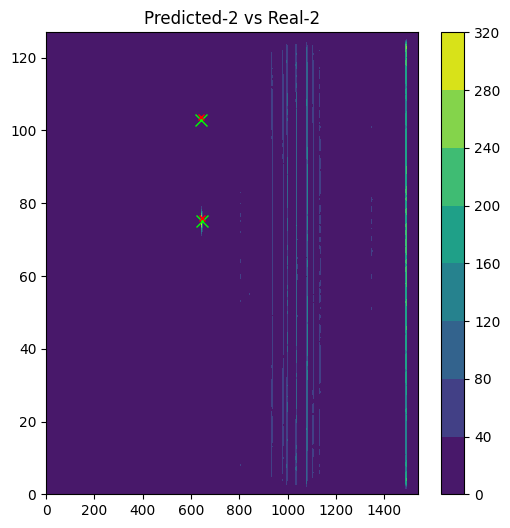

{'boxes': tensor([[546.8011,  88.9019, 554.4440,  99.2703],
        [546.9843,  65.0406, 555.5036,  75.0795]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9930, 0.9873], device='cuda:0')}
prediction=tensor([546.8011,  88.9019, 554.4440,  99.2703]) score=0.9930447936058044
Prediction coordinate x=550.62255859375 y=94.08610534667969
prediction=tensor([546.9843,  65.0406, 555.5036,  75.0795]) score=0.9873064756393433
Prediction coordinate x=551.2439575195312 y=70.06005096435547


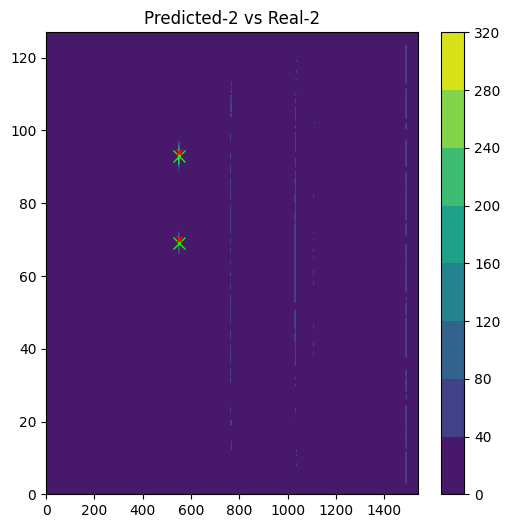

{'boxes': tensor([[339.4085, 117.0475, 349.7781, 127.1625],
        [352.2867,  34.9179, 362.6418,  45.2778]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.9064], device='cuda:0')}
prediction=tensor([339.4085, 117.0475, 349.7781, 127.1625]) score=0.9978439807891846
Prediction coordinate x=344.59332275390625 y=122.1050033569336
prediction=tensor([352.2867,  34.9179, 362.6418,  45.2778]) score=0.9063518643379211
Prediction coordinate x=357.4642639160156 y=40.09788131713867


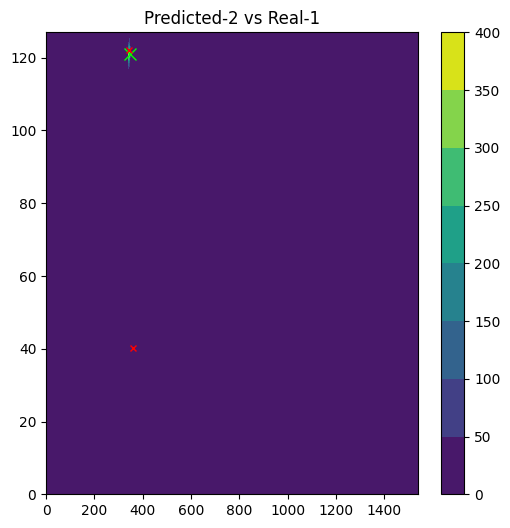

{'boxes': tensor([[ 784.4404,  102.9538,  792.8924,  113.0258],
        [ 789.4012,   64.9361,  798.1852,   74.9305],
        [ 573.3458,   77.9610,  578.7800,   87.8775],
        [1151.0056,  102.9816, 1158.7572,  112.9584],
        [ 575.5258,   53.0617,  580.9475,   63.0366],
        [ 569.8694,  102.9681,  574.7614,  113.0520],
        [ 789.7047,   28.0669,  798.1447,   37.5354],
        [1156.2966,   27.8195, 1164.5801,   37.8341],
        [ 575.4967,   27.9961,  580.7924,   38.0734],
        [ 573.2274,    2.2134,  578.9703,   12.2988],
        [1158.3145,    2.4672, 1165.1057,   12.7305]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.9983, 0.9980, 0.9950, 0.9881, 0.9872, 0.9694, 0.9479, 0.9430,
        0.9235, 0.2558], device='cuda:0')}
prediction=tensor([784.4404, 102.9538, 792.8924, 113.0258]) score=0.9986374974250793
Prediction coordinate x=788.6663818359375 y=107.98979187011719
prediction=tensor([789.401

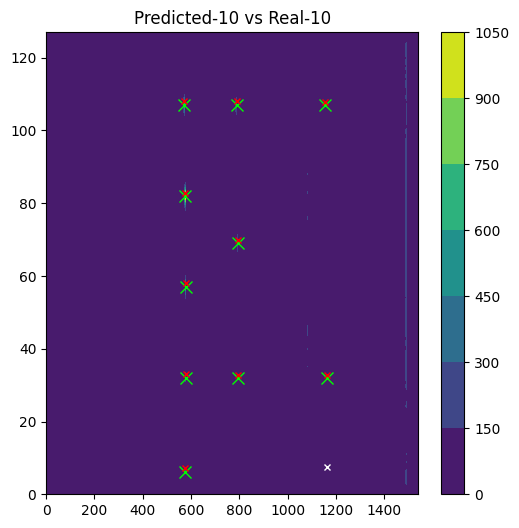

{'boxes': tensor([[499.3223, 122.1401, 505.9677, 128.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9785], device='cuda:0')}
prediction=tensor([499.3223, 122.1401, 505.9677, 128.0000]) score=0.9784619808197021
Prediction coordinate x=502.64501953125 y=125.07003021240234


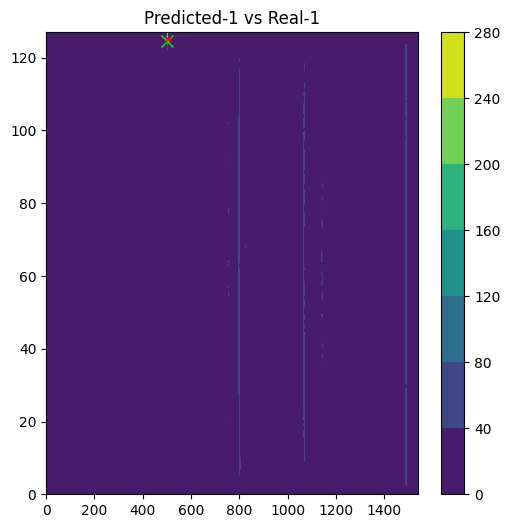

{'boxes': tensor([[4.0832e+02, 9.2254e+01, 4.1318e+02, 1.0182e+02],
        [6.2717e+02, 8.0826e+00, 6.3627e+02, 1.7780e+01],
        [9.9016e+02, 9.2164e+01, 9.9943e+02, 1.0209e+02],
        [6.2324e+02, 9.2009e+01, 6.3162e+02, 1.0199e+02],
        [4.1186e+02, 1.0866e-01, 4.1585e+02, 7.7001e+00],
        [4.1329e+02, 1.8047e+01, 4.1728e+02, 2.7967e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.9928, 0.9920, 0.9242, 0.7924, 0.6244], device='cuda:0')}
prediction=tensor([408.3214,  92.2542, 413.1758, 101.8207]) score=0.99540114402771
Prediction coordinate x=410.74859619140625 y=97.03746032714844
prediction=tensor([627.1674,   8.0826, 636.2692,  17.7804]) score=0.992767333984375
Prediction coordinate x=631.7183227539062 y=12.931468963623047
prediction=tensor([990.1592,  92.1641, 999.4269, 102.0942]) score=0.9919520020484924
Prediction coordinate x=994.7930908203125 y=97.12919616699219
prediction=tensor([623.2446,  92.0090, 631.

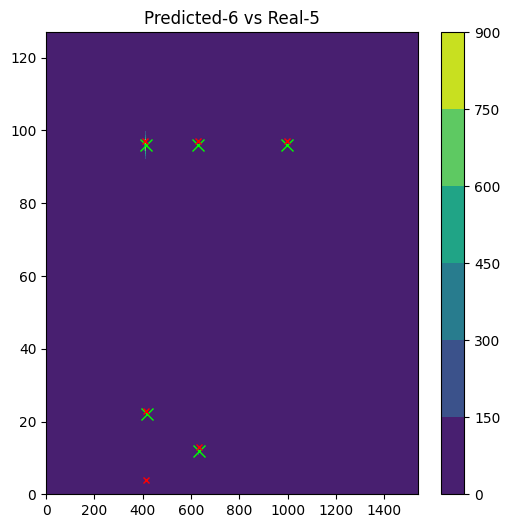

{'boxes': tensor([[263.8695,  92.9744, 273.2609, 102.7265],
        [272.0525,   6.7360, 281.4158,  16.9284]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.9015], device='cuda:0')}
prediction=tensor([263.8695,  92.9744, 273.2609, 102.7265]) score=0.9958162903785706
Prediction coordinate x=268.56524658203125 y=97.8504638671875
prediction=tensor([272.0525,   6.7360, 281.4158,  16.9284]) score=0.9015329480171204
Prediction coordinate x=276.734130859375 y=11.832191467285156


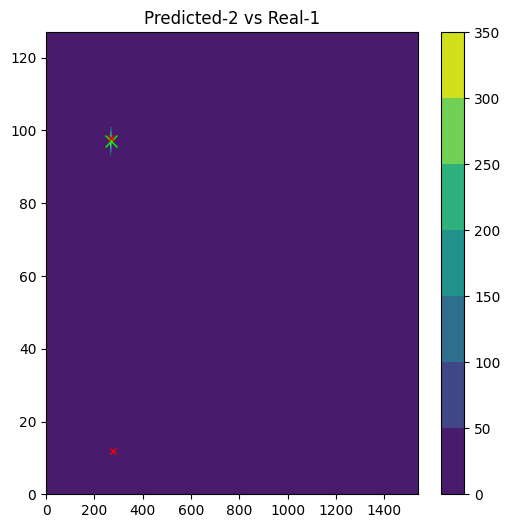

{'boxes': tensor([[629.9550,  20.9156, 636.5595,  31.2801],
        [633.5296,  49.0383, 640.1923,  58.8740],
        [633.3547,  76.9977, 639.7803,  87.0752]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.9872, 0.8806], device='cuda:0')}
prediction=tensor([629.9550,  20.9156, 636.5595,  31.2801]) score=0.998802661895752
Prediction coordinate x=633.2572021484375 y=26.097808837890625
prediction=tensor([633.5296,  49.0383, 640.1923,  58.8740]) score=0.987168550491333
Prediction coordinate x=636.8609619140625 y=53.956119537353516
prediction=tensor([633.3547,  76.9977, 639.7803,  87.0752]) score=0.8805630207061768
Prediction coordinate x=636.5675048828125 y=82.03641510009766


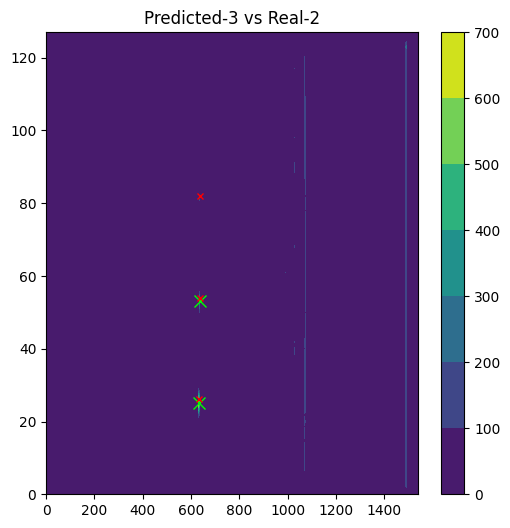

{'boxes': tensor([[513.1722, 113.8464, 518.5159, 124.1588],
        [520.6270,  45.9523, 526.3308,  55.9514],
        [519.7158,  67.7437, 525.1099,  77.7391],
        [517.8470,  91.0173, 522.7784, 101.0402]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.9952, 0.9908, 0.9251], device='cuda:0')}
prediction=tensor([513.1722, 113.8464, 518.5159, 124.1588]) score=0.9986289739608765
Prediction coordinate x=515.8440551757812 y=119.00262451171875
prediction=tensor([520.6270,  45.9523, 526.3308,  55.9514]) score=0.9952389001846313
Prediction coordinate x=523.4788818359375 y=50.95185470581055
prediction=tensor([519.7158,  67.7437, 525.1099,  77.7391]) score=0.9907858371734619
Prediction coordinate x=522.412841796875 y=72.74140930175781
prediction=tensor([517.8470,  91.0173, 522.7784, 101.0402]) score=0.9250743985176086
Prediction coordinate x=520.312744140625 y=96.02873229980469


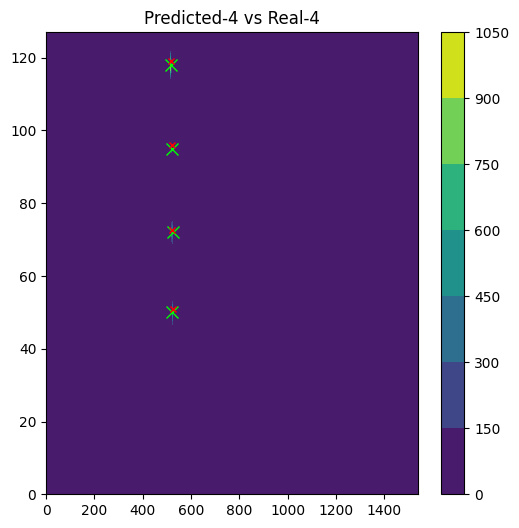

{'boxes': tensor([[298.8841, 110.9833, 303.7738, 120.9932]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9884], device='cuda:0')}
prediction=tensor([298.8841, 110.9833, 303.7738, 120.9932]) score=0.988387405872345
Prediction coordinate x=301.3289794921875 y=115.9882583618164


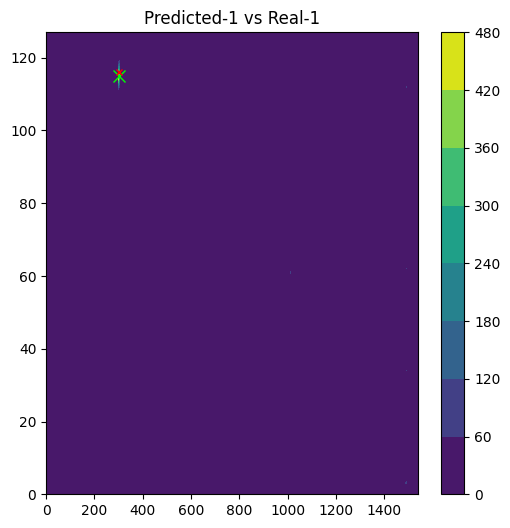

{'boxes': tensor([[ 726.8632,  123.0969,  734.8302,  128.0000],
        [ 509.5787,   21.1426,  514.0395,   30.8982],
        [ 513.4984,  110.9245,  518.4719,  120.9752],
        [ 512.5250,   42.9872,  518.0222,   52.8560],
        [ 729.5734,   87.8390,  737.7623,   97.9934],
        [ 514.3228,   64.7254,  519.4858,   75.1090],
        [ 724.0032,   21.0686,  733.0674,   31.2792],
        [ 514.4333,   87.7168,  519.4345,   97.9571],
        [1095.6459,   88.8060, 1103.6864,   98.1648],
        [ 728.3380,   53.9353,  737.1540,   64.3007],
        [1091.5812,   20.9942, 1100.3284,   30.7253]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9899, 0.9797, 0.9678, 0.9572, 0.9317, 0.8890, 0.8853, 0.8364, 0.7674,
        0.7579, 0.4060], device='cuda:0')}
prediction=tensor([726.8632, 123.0969, 734.8302, 128.0000]) score=0.9898805618286133
Prediction coordinate x=730.8466796875 y=125.54845428466797
prediction=tensor([509.5787, 

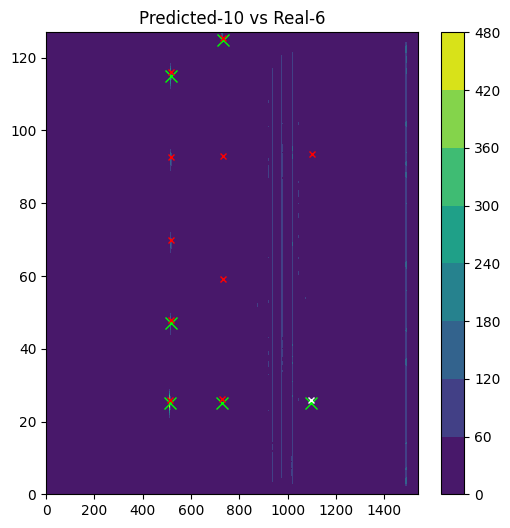

{'boxes': tensor([[185.1421,   0.2800, 189.6500,   9.8190],
        [201.9128, 112.2015, 207.7983, 122.0250]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9890, 0.0530], device='cuda:0')}
prediction=tensor([185.1421,   0.2800, 189.6500,   9.8190]) score=0.988997757434845
Prediction coordinate x=187.39605712890625 y=5.049495220184326
prediction=tensor([201.9128, 112.2015, 207.7983, 122.0250]) score=0.053009070456027985
----->Ignoring the prediction at x=204.85557556152344 y=117.11329650878906 with score=0.053009070456027985


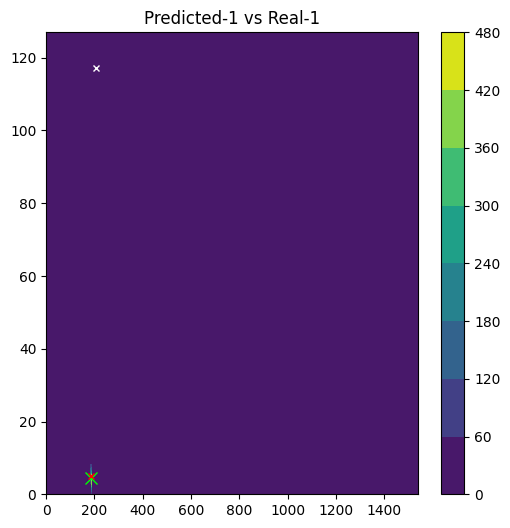

{'boxes': tensor([[485.6587,  17.8307, 491.1564,  27.9993],
        [699.6632,   6.8815, 708.4620,  17.0009]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.9231], device='cuda:0')}
prediction=tensor([485.6587,  17.8307, 491.1564,  27.9993]) score=0.9974073767662048
Prediction coordinate x=488.40753173828125 y=22.915042877197266
prediction=tensor([699.6632,   6.8815, 708.4620,  17.0009]) score=0.9230908155441284
Prediction coordinate x=704.0626220703125 y=11.941205024719238


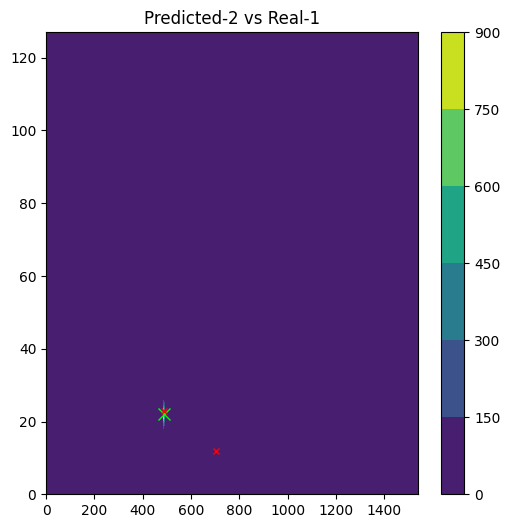

{'boxes': tensor([[307.8351,  57.0941, 311.6622,  66.9200],
        [306.8207,  72.1921, 311.1072,  82.1262],
        [309.9688,  41.7859, 314.6116,  52.3983],
        [302.8540,  87.2334, 307.4213,  96.9336],
        [305.2866,  42.3102, 309.4773,  52.9004]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9696, 0.8842, 0.7868, 0.4729, 0.0553], device='cuda:0')}
prediction=tensor([307.8351,  57.0941, 311.6622,  66.9200]) score=0.9696323871612549
Prediction coordinate x=309.7486267089844 y=62.00701904296875
prediction=tensor([306.8207,  72.1921, 311.1072,  82.1262]) score=0.8841686844825745
Prediction coordinate x=308.9639587402344 y=77.1591796875
prediction=tensor([309.9688,  41.7859, 314.6116,  52.3983]) score=0.78676438331604
Prediction coordinate x=312.2901611328125 y=47.09205627441406
prediction=tensor([302.8540,  87.2334, 307.4213,  96.9336]) score=0.47289353609085083
----->Ignoring the prediction at x=305.13763427734375 y=92.08349609375 

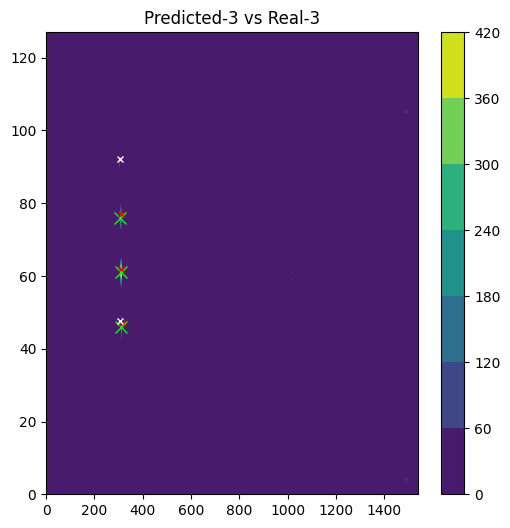

{'boxes': tensor([[825.9989,  39.9859, 835.1639,  50.1599],
        [827.7369,  79.7777, 836.6387,  89.7192]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.8099], device='cuda:0')}
prediction=tensor([825.9989,  39.9859, 835.1639,  50.1599]) score=0.9989356398582458
Prediction coordinate x=830.5814208984375 y=45.07289123535156
prediction=tensor([827.7369,  79.7777, 836.6387,  89.7192]) score=0.80994713306427
Prediction coordinate x=832.1878051757812 y=84.74845123291016


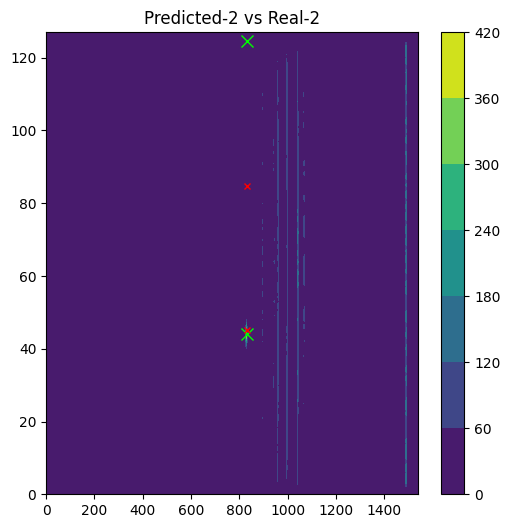

{'boxes': tensor([[442.6987,  16.8045, 449.3709,  26.7328],
        [443.8895,  36.7216, 449.7304,  46.9984],
        [440.3919,  75.8239, 446.2504,  86.1149],
        [437.5004,  94.8344, 442.9611, 105.1629]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.9936, 0.9043, 0.8192], device='cuda:0')}
prediction=tensor([442.6987,  16.8045, 449.3709,  26.7328]) score=0.9970812201499939
Prediction coordinate x=446.0347900390625 y=21.768634796142578
prediction=tensor([443.8895,  36.7216, 449.7304,  46.9984]) score=0.9935911893844604
Prediction coordinate x=446.8099365234375 y=41.86003112792969
prediction=tensor([440.3919,  75.8239, 446.2504,  86.1149]) score=0.9043463468551636
Prediction coordinate x=443.3211364746094 y=80.96940612792969
prediction=tensor([437.5004,  94.8344, 442.9611, 105.1629]) score=0.8191559910774231
Prediction coordinate x=440.23077392578125 y=99.99864196777344


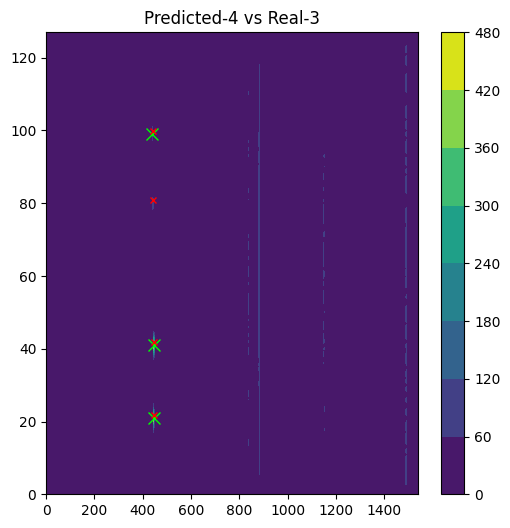

{'boxes': tensor([[528.1929,  73.9668, 537.6671,  84.0189],
        [523.7468,  28.9765, 533.8542,  38.9249],
        [309.2298,  29.0125, 314.3408,  39.1400],
        [313.0879,  74.4020, 318.3720,  83.9320],
        [890.6274,  28.8508, 902.1088,  39.0058],
        [528.1017,  51.9962, 537.3917,  62.2575],
        [313.0994,  58.9237, 318.7139,  68.9985],
        [895.2299,  74.2012, 906.2670,  84.1010],
        [518.6205,   6.0686, 524.8389,  16.1424],
        [305.8799,  13.8489, 311.1146,  23.0528],
        [313.5674,  43.0180, 319.0845,  52.5146]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.9961, 0.9960, 0.9903, 0.9898, 0.9896, 0.9889, 0.8848, 0.8002,
        0.6821, 0.2139], device='cuda:0')}
prediction=tensor([528.1929,  73.9668, 537.6671,  84.0189]) score=0.9988163709640503
Prediction coordinate x=532.929931640625 y=78.99287414550781
prediction=tensor([523.7468,  28.9765, 533.8542,  38.9249]) score=0.9960

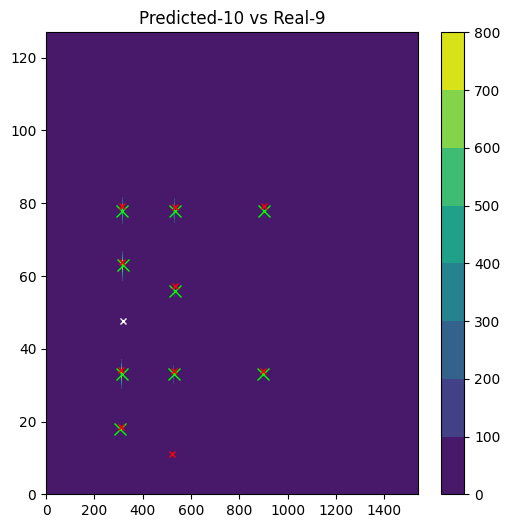

{'boxes': tensor([[6.3270e+02, 5.5044e+01, 6.3902e+02, 6.4960e+01],
        [6.3006e+02, 8.7217e-02, 6.3740e+02, 8.2256e+00],
        [6.2506e+02, 1.1096e+02, 6.3154e+02, 1.2084e+02],
        [6.3263e+02, 2.7237e+01, 6.3936e+02, 3.6844e+01],
        [6.3026e+02, 8.3070e+01, 6.3683e+02, 9.3033e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.9967, 0.9195, 0.8006, 0.7651], device='cuda:0')}
prediction=tensor([632.7004,  55.0443, 639.0207,  64.9601]) score=0.9979901313781738
Prediction coordinate x=635.860595703125 y=60.00220489501953
prediction=tensor([6.3006e+02, 8.7217e-02, 6.3740e+02, 8.2256e+00]) score=0.9966625571250916
Prediction coordinate x=633.7285766601562 y=4.1563849449157715
prediction=tensor([625.0638, 110.9561, 631.5382, 120.8399]) score=0.9195109009742737
Prediction coordinate x=628.301025390625 y=115.89797973632812
prediction=tensor([632.6323,  27.2371, 639.3580,  36.8436]) score=0.8006474375724792
Prediction coordin

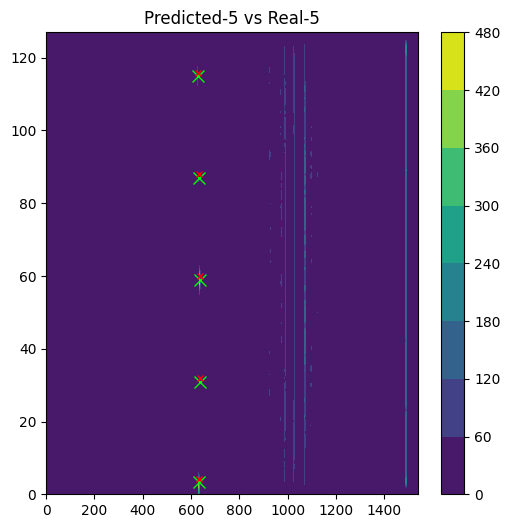

{'boxes': tensor([[749.0591,  87.9859, 757.4560,  97.9755],
        [532.8109,  99.9456, 537.9489, 109.9720]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9522, 0.8697], device='cuda:0')}
prediction=tensor([749.0591,  87.9859, 757.4560,  97.9755]) score=0.9522154927253723
Prediction coordinate x=753.257568359375 y=92.98069763183594
prediction=tensor([532.8109,  99.9456, 537.9489, 109.9720]) score=0.8696683645248413
Prediction coordinate x=535.3798828125 y=104.95879364013672


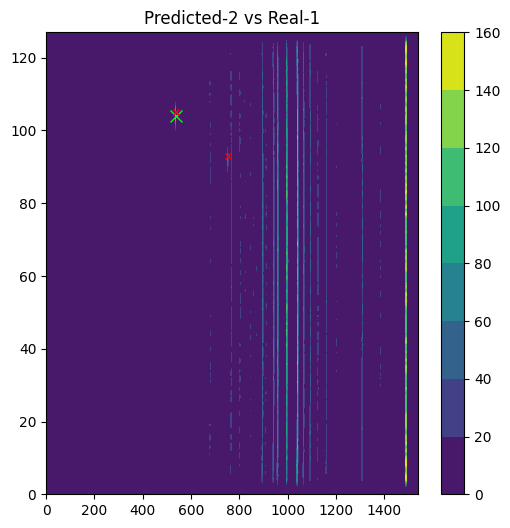

{'boxes': tensor([[359.2668, 108.0083, 363.4882, 118.2266],
        [370.1802,  21.9526, 374.6600,  31.9794],
        [369.1233,   5.1540, 374.4359,  15.1410]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9862, 0.7231, 0.6178], device='cuda:0')}
prediction=tensor([359.2668, 108.0083, 363.4882, 118.2266]) score=0.9861674904823303
Prediction coordinate x=361.37750244140625 y=113.11744689941406
prediction=tensor([370.1802,  21.9526, 374.6600,  31.9794]) score=0.7230560183525085
Prediction coordinate x=372.42010498046875 y=26.966022491455078
prediction=tensor([369.1233,   5.1540, 374.4359,  15.1410]) score=0.6177940368652344
Prediction coordinate x=371.7795715332031 y=10.147494316101074


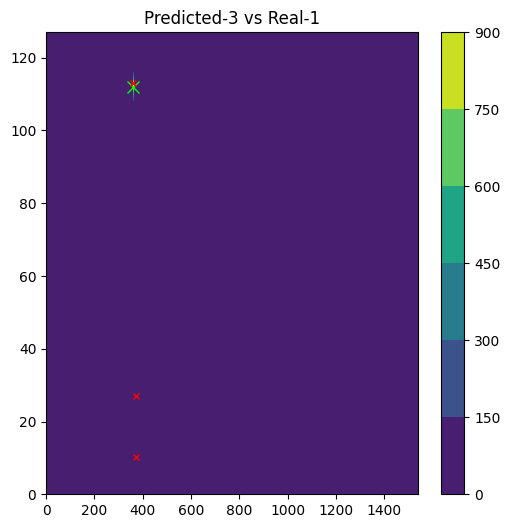

{'boxes': tensor([[327.3935,  65.7252, 332.7221,  75.4893],
        [322.3286,  98.0758, 326.7392, 107.7564],
        [325.0045,  82.7445, 330.1192,  92.6948],
        [326.4167,  50.8143, 331.1330,  60.4415]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.9808, 0.9589, 0.7602], device='cuda:0')}
prediction=tensor([327.3935,  65.7252, 332.7221,  75.4893]) score=0.9969474673271179
Prediction coordinate x=330.05780029296875 y=70.60726928710938
prediction=tensor([322.3286,  98.0758, 326.7392, 107.7564]) score=0.9808252453804016
Prediction coordinate x=324.53387451171875 y=102.91609954833984
prediction=tensor([325.0045,  82.7445, 330.1192,  92.6948]) score=0.9589101076126099
Prediction coordinate x=327.5618591308594 y=87.71966552734375
prediction=tensor([326.4167,  50.8143, 331.1330,  60.4415]) score=0.7602229118347168
Prediction coordinate x=328.77484130859375 y=55.627899169921875


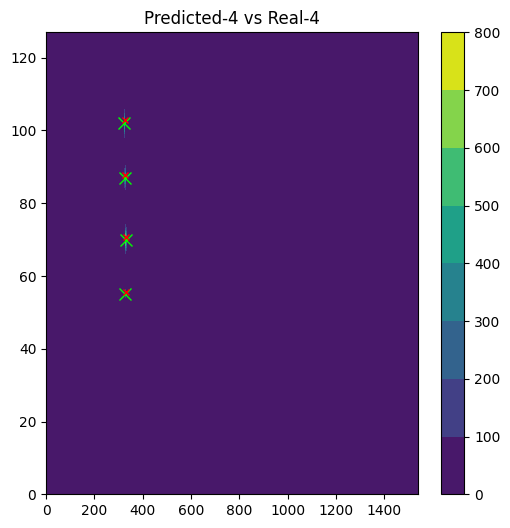

{'boxes': tensor([[465.9627,  85.1456, 475.6155,  94.9694],
        [465.6514, 104.8181, 474.6319, 114.9404],
        [467.4758,  63.9212, 477.0257,  74.0017]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9751, 0.9305, 0.8351], device='cuda:0')}
prediction=tensor([465.9627,  85.1456, 475.6155,  94.9694]) score=0.9751303791999817
Prediction coordinate x=470.78912353515625 y=90.05746459960938
prediction=tensor([465.6514, 104.8181, 474.6319, 114.9404]) score=0.9304589033126831
Prediction coordinate x=470.1416015625 y=109.87922668457031
prediction=tensor([467.4758,  63.9212, 477.0257,  74.0017]) score=0.835063099861145
Prediction coordinate x=472.250732421875 y=68.96143341064453


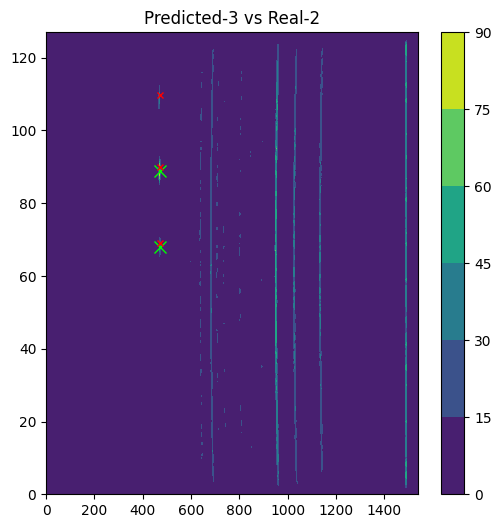

{'boxes': tensor([[557.4192,  97.7624, 563.3860, 108.1282]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}
prediction=tensor([557.4192,  97.7624, 563.3860, 108.1282]) score=0.9962498545646667
Prediction coordinate x=560.402587890625 y=102.9453125


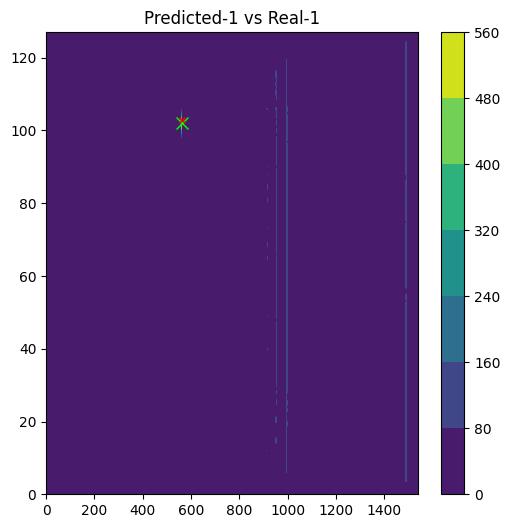

{'boxes': tensor([[516.1478, 112.9994, 522.1454, 123.0083],
        [304.4347, 106.1307, 309.3963, 115.9995],
        [310.8569,  30.2274, 314.0183,  39.8221],
        [525.5482,  45.1121, 535.3777,  54.9658],
        [310.8946,  44.7249, 315.3423,  55.0424],
        [892.2991,  44.7989, 903.2271,  54.7791],
        [299.2669, 122.9156, 303.5471, 128.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9949, 0.9932, 0.9797, 0.9538, 0.9123, 0.8403, 0.1128],
       device='cuda:0')}
prediction=tensor([516.1478, 112.9994, 522.1454, 123.0083]) score=0.9949072003364563
Prediction coordinate x=519.1466064453125 y=118.00387573242188
prediction=tensor([304.4347, 106.1307, 309.3963, 115.9995]) score=0.9932041168212891
Prediction coordinate x=306.91552734375 y=111.06509399414062
prediction=tensor([310.8569,  30.2274, 314.0183,  39.8221]) score=0.979738712310791
Prediction coordinate x=312.4376220703125 y=35.02471160888672
prediction=tensor([525.

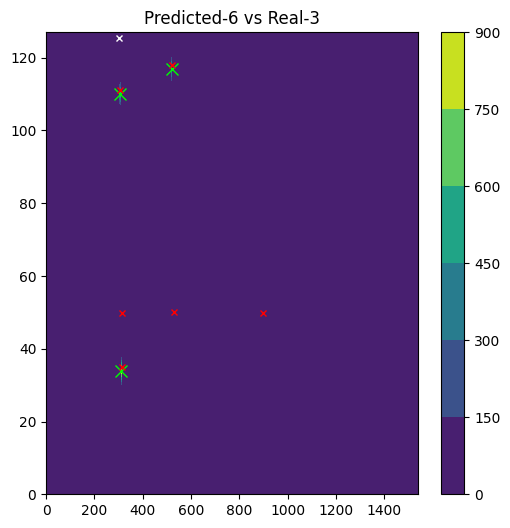

{'boxes': tensor([[619.2424,  16.9932, 626.3242,  27.0468],
        [621.0732,  44.8108, 628.0594,  54.6086],
        [620.0073,  71.8861, 627.2599,  81.9490]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.9940, 0.7112], device='cuda:0')}
prediction=tensor([619.2424,  16.9932, 626.3242,  27.0468]) score=0.9952999353408813
Prediction coordinate x=622.7833251953125 y=22.01998519897461
prediction=tensor([621.0732,  44.8108, 628.0594,  54.6086]) score=0.9939538836479187
Prediction coordinate x=624.5662841796875 y=49.709716796875
prediction=tensor([620.0073,  71.8861, 627.2599,  81.9490]) score=0.711248517036438
Prediction coordinate x=623.6336059570312 y=76.91757202148438


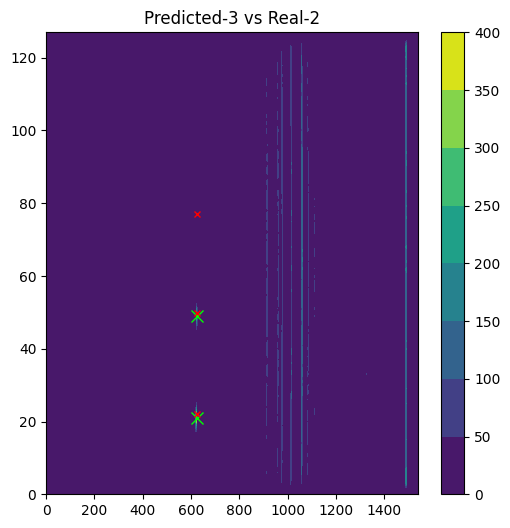

{'boxes': tensor([[520.4470,  71.9878, 526.0834,  81.9686],
        [519.4179,  48.9618, 524.5243,  59.0390],
        [516.3021, 117.9964, 522.0312, 127.9983],
        [519.9631,  95.2440, 524.9964, 105.1288]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.9932, 0.9830, 0.8938], device='cuda:0')}
prediction=tensor([520.4470,  71.9878, 526.0834,  81.9686]) score=0.997668445110321
Prediction coordinate x=523.2651977539062 y=76.97817993164062
prediction=tensor([519.4179,  48.9618, 524.5243,  59.0390]) score=0.99321448802948
Prediction coordinate x=521.9710693359375 y=54.000389099121094
prediction=tensor([516.3021, 117.9964, 522.0312, 127.9983]) score=0.9829922318458557
Prediction coordinate x=519.1666259765625 y=122.99735260009766
prediction=tensor([519.9631,  95.2440, 524.9964, 105.1288]) score=0.8938025832176208
Prediction coordinate x=522.479736328125 y=100.18641662597656


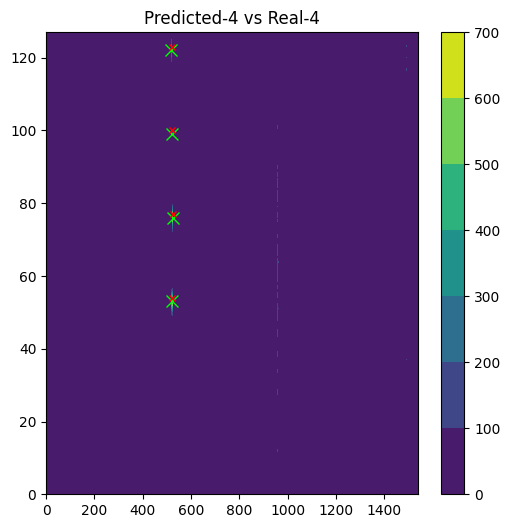

{'boxes': tensor([[562.7812,  57.9586, 569.7648,  67.9627],
        [563.5203,  33.9231, 569.5865,  44.0889],
        [561.8532,   7.9204, 568.1357,  17.8611],
        [560.3549,  81.8214, 566.7866,  91.7271]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.9981, 0.9754, 0.9159], device='cuda:0')}
prediction=tensor([562.7812,  57.9586, 569.7648,  67.9627]) score=0.9983649849891663
Prediction coordinate x=566.27294921875 y=62.96064758300781
prediction=tensor([563.5203,  33.9231, 569.5865,  44.0889]) score=0.9981021285057068
Prediction coordinate x=566.5534057617188 y=39.006019592285156
prediction=tensor([561.8532,   7.9204, 568.1357,  17.8611]) score=0.9753586053848267
Prediction coordinate x=564.9945068359375 y=12.890737533569336
prediction=tensor([560.3549,  81.8214, 566.7866,  91.7271]) score=0.9159373641014099
Prediction coordinate x=563.5707397460938 y=86.77424621582031


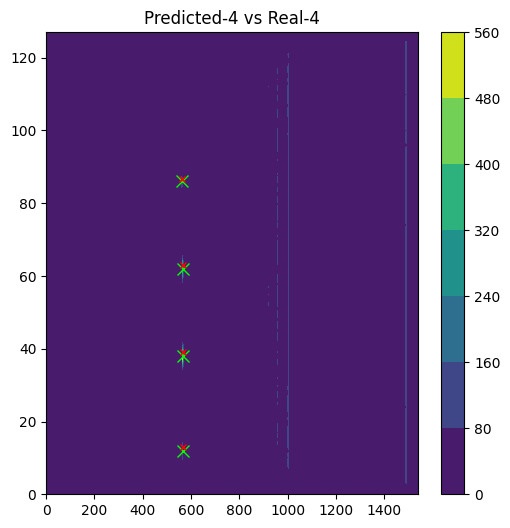

{'boxes': tensor([[ 529.4606,   69.6597,  535.4746,   80.0833],
        [ 527.2474,   93.2333,  533.7292,  103.1417],
        [ 522.8562,  115.5626,  529.1685,  125.6833],
        [ 530.1038,   46.9514,  536.3907,   56.7516],
        [1046.9637,    4.3595, 1056.6965,   14.9120]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.9948, 0.9325, 0.7665, 0.0517], device='cuda:0')}
prediction=tensor([529.4606,  69.6597, 535.4746,  80.0833]) score=0.999366819858551
Prediction coordinate x=532.4675903320312 y=74.8714828491211
prediction=tensor([527.2474,  93.2333, 533.7292, 103.1417]) score=0.9948267340660095
Prediction coordinate x=530.48828125 y=98.18751525878906
prediction=tensor([522.8562, 115.5626, 529.1685, 125.6833]) score=0.9325245022773743
Prediction coordinate x=526.0123291015625 y=120.62294006347656
prediction=tensor([530.1038,  46.9514, 536.3907,  56.7516]) score=0.7664756774902344
Prediction coordinate x=533.2472534179688 y=51.85150

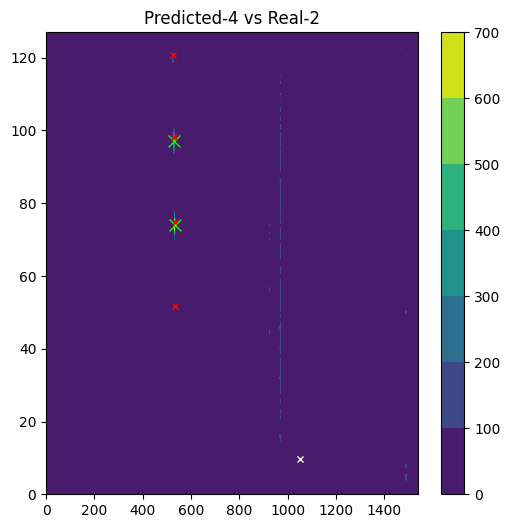

{'boxes': tensor([[ 787.7000,  123.0749,  795.6642,  127.8856],
        [ 576.6379,   83.8058,  581.7861,   93.9172],
        [1158.0044,   84.0774, 1165.2754,   93.9055],
        [ 574.4266,  110.0197,  580.3994,  119.8883],
        [ 791.3638,   83.8780,  798.9098,   93.8511],
        [ 576.2820,   59.1534,  582.0421,   69.2520],
        [1158.1484,    1.8993, 1165.6122,   11.5747]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.9935, 0.9886, 0.9878, 0.9867, 0.3177, 0.1105],
       device='cuda:0')}
prediction=tensor([787.7000, 123.0749, 795.6642, 127.8856]) score=0.9991136193275452
Prediction coordinate x=791.68212890625 y=125.48023986816406
prediction=tensor([576.6379,  83.8058, 581.7861,  93.9172]) score=0.9935446977615356
Prediction coordinate x=579.2119750976562 y=88.86149597167969
prediction=tensor([1158.0044,   84.0774, 1165.2754,   93.9055]) score=0.9886448383331299
Prediction coordinate x=1161.639892578125 y=88.991432

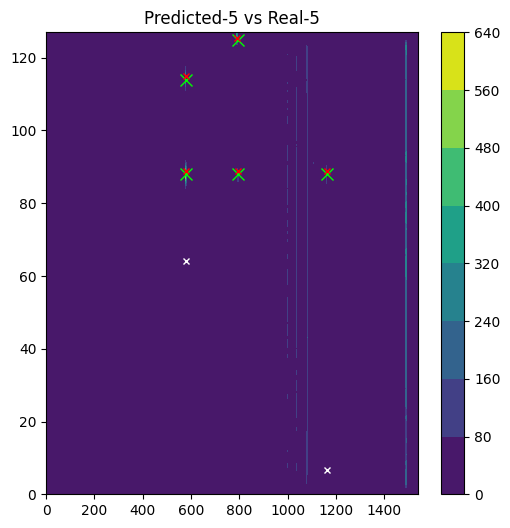

{'boxes': tensor([[392.5692,  49.1616, 398.6652,  58.9847],
        [390.2826,  64.9637, 395.9389,  75.1219],
        [391.3240,  30.9177, 396.6260,  40.5703],
        [390.6039,  13.0174, 397.3520,  23.1045]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9078, 0.7412, 0.5641], device='cuda:0')}
prediction=tensor([392.5692,  49.1616, 398.6652,  58.9847]) score=0.9996508359909058
Prediction coordinate x=395.6172180175781 y=54.0731201171875
prediction=tensor([390.2826,  64.9637, 395.9389,  75.1219]) score=0.9078267812728882
Prediction coordinate x=393.1107482910156 y=70.04275512695312
prediction=tensor([391.3240,  30.9177, 396.6260,  40.5703]) score=0.7411825656890869
Prediction coordinate x=393.9749755859375 y=35.74400329589844
prediction=tensor([390.6039,  13.0174, 397.3520,  23.1045]) score=0.5640706419944763
Prediction coordinate x=393.97796630859375 y=18.060955047607422


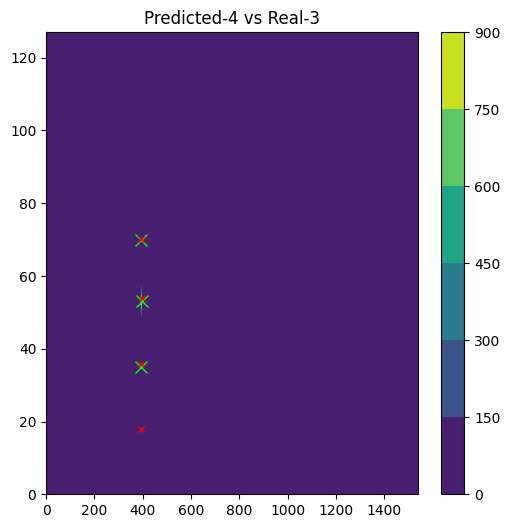

{'boxes': tensor([[428.2516,  75.9608, 434.2224,  85.7998],
        [427.3495,  94.9476, 433.4049, 105.0115],
        [429.3817,  56.9520, 435.0179,  66.8069],
        [422.9334, 114.6336, 428.9196, 123.8648]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.9792, 0.5516, 0.2046], device='cuda:0')}
prediction=tensor([428.2516,  75.9608, 434.2224,  85.7998]) score=0.9992446899414062
Prediction coordinate x=431.2369689941406 y=80.88029479980469
prediction=tensor([427.3495,  94.9476, 433.4049, 105.0115]) score=0.9792088270187378
Prediction coordinate x=430.377197265625 y=99.97953796386719
prediction=tensor([429.3817,  56.9520, 435.0179,  66.8069]) score=0.5515846014022827
Prediction coordinate x=432.19976806640625 y=61.879478454589844
prediction=tensor([422.9334, 114.6336, 428.9196, 123.8648]) score=0.20461004972457886
----->Ignoring the prediction at x=425.9264831542969 y=119.24917602539062 with score=0.20461004972457886


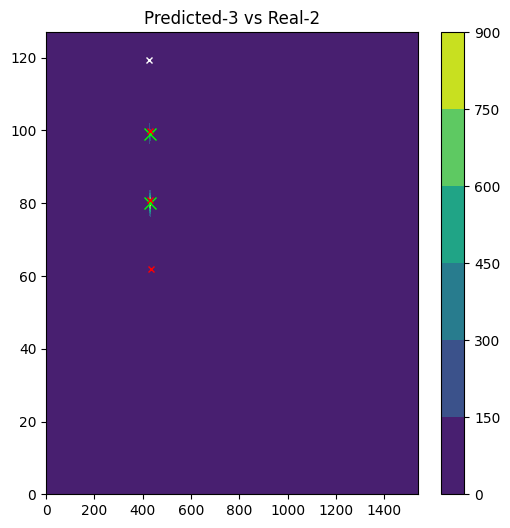

{'boxes': tensor([[280.4823, 115.8947, 285.0518, 125.9615],
        [294.0596,   0.0000, 298.0487,   7.4793]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9813, 0.3134], device='cuda:0')}
prediction=tensor([280.4823, 115.8947, 285.0518, 125.9615]) score=0.9812889099121094
Prediction coordinate x=282.7670593261719 y=120.92809295654297
prediction=tensor([294.0596,   0.0000, 298.0487,   7.4793]) score=0.3133607804775238
----->Ignoring the prediction at x=296.05413818359375 y=3.73964786529541 with score=0.3133607804775238


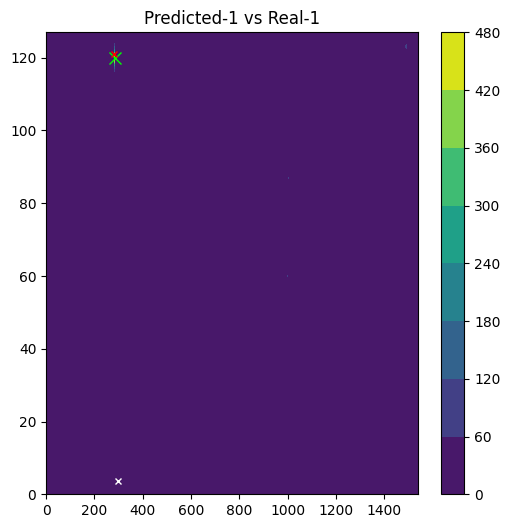

{'boxes': tensor([[707.2724,  42.9662, 717.7428,  52.9883],
        [706.4114,   9.9828, 715.8824,  19.8766]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.8970], device='cuda:0')}
prediction=tensor([707.2724,  42.9662, 717.7428,  52.9883]) score=0.997305154800415
Prediction coordinate x=712.507568359375 y=47.977256774902344
prediction=tensor([706.4114,   9.9828, 715.8824,  19.8766]) score=0.8969857692718506
Prediction coordinate x=711.1469116210938 y=14.929707527160645


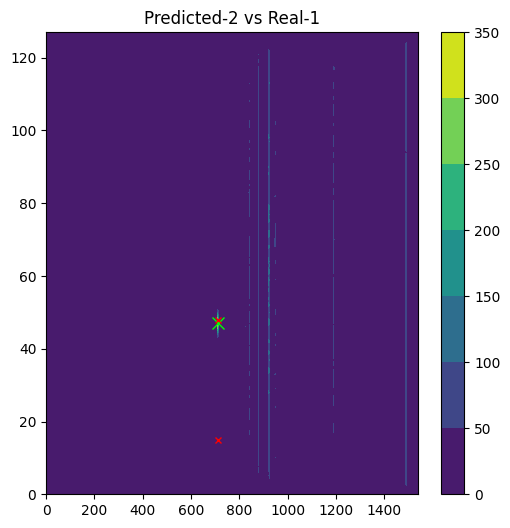

{'boxes': tensor([[222.6310,  79.8010, 234.8450,  89.8339],
        [222.3223,  66.7944, 233.3052,  76.7763]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.9770], device='cuda:0')}
prediction=tensor([222.6310,  79.8010, 234.8450,  89.8339]) score=0.997020423412323
Prediction coordinate x=228.7379608154297 y=84.81748962402344
prediction=tensor([222.3223,  66.7944, 233.3052,  76.7763]) score=0.9769846200942993
Prediction coordinate x=227.8137664794922 y=71.78535461425781


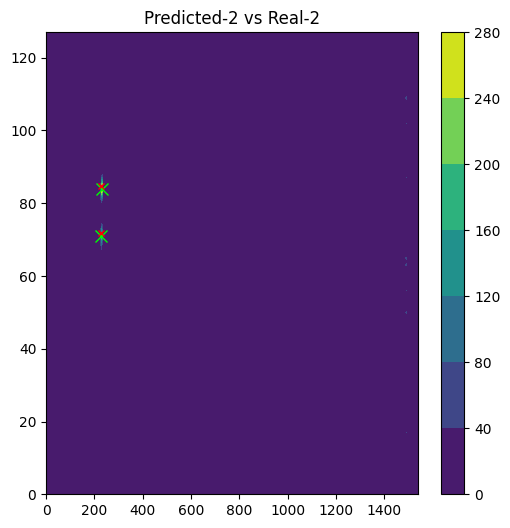

{'boxes': tensor([[467.4140,  54.9951, 477.1114,  65.0400],
        [465.5066,  14.1833, 475.0145,  23.8302],
        [466.1717,  34.9739, 475.7254,  45.0953]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9768, 0.8974, 0.8498], device='cuda:0')}
prediction=tensor([467.4140,  54.9951, 477.1114,  65.0400]) score=0.9767693877220154
Prediction coordinate x=472.2627258300781 y=60.017555236816406
prediction=tensor([465.5066,  14.1833, 475.0145,  23.8302]) score=0.8973566293716431
Prediction coordinate x=470.26055908203125 y=19.006759643554688
prediction=tensor([466.1717,  34.9739, 475.7254,  45.0953]) score=0.849825918674469
Prediction coordinate x=470.94854736328125 y=40.03460693359375


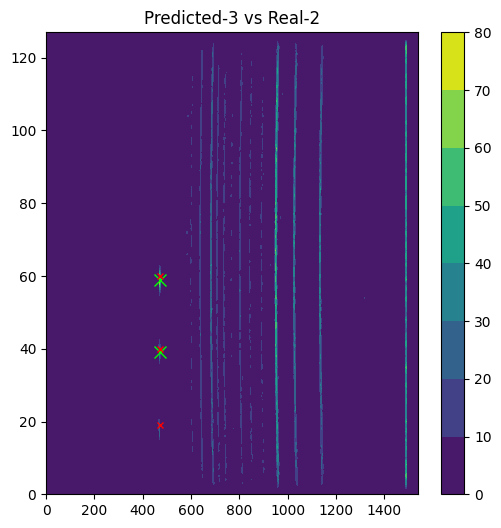

{'boxes': tensor([[733.1346,  38.0415, 741.6243,  48.1101],
        [518.0048,  37.9688, 523.0848,  48.1175],
        [732.2646,  72.0604, 740.9633,  82.2091],
        [517.5665,  59.9495, 523.5909,  70.0850],
        [730.2445,   3.1856, 739.8055,  12.9571],
        [517.1467,  15.0382, 522.0171,  24.9965],
        [516.5356,  81.9805, 521.7701,  92.2851]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.9936, 0.9926, 0.9606, 0.9013, 0.8463, 0.7502],
       device='cuda:0')}
prediction=tensor([733.1346,  38.0415, 741.6243,  48.1101]) score=0.998244047164917
Prediction coordinate x=737.3794555664062 y=43.07582473754883
prediction=tensor([518.0048,  37.9688, 523.0848,  48.1175]) score=0.9936181306838989
Prediction coordinate x=520.5447998046875 y=43.04315185546875
prediction=tensor([732.2646,  72.0604, 740.9633,  82.2091]) score=0.9925965070724487
Prediction coordinate x=736.6139526367188 y=77.13472747802734
prediction=tensor([517.

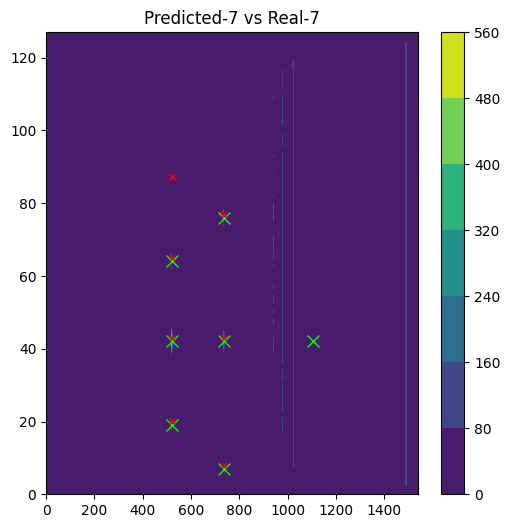

{'boxes': tensor([[630.9377,  13.7732, 637.1087,  23.9846],
        [632.7543,  42.1554, 639.1694,  52.3582]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.7273], device='cuda:0')}
prediction=tensor([630.9377,  13.7732, 637.1087,  23.9846]) score=0.9956502318382263
Prediction coordinate x=634.023193359375 y=18.87887954711914
prediction=tensor([632.7543,  42.1554, 639.1694,  52.3582]) score=0.7273451089859009
Prediction coordinate x=635.9619140625 y=47.256813049316406


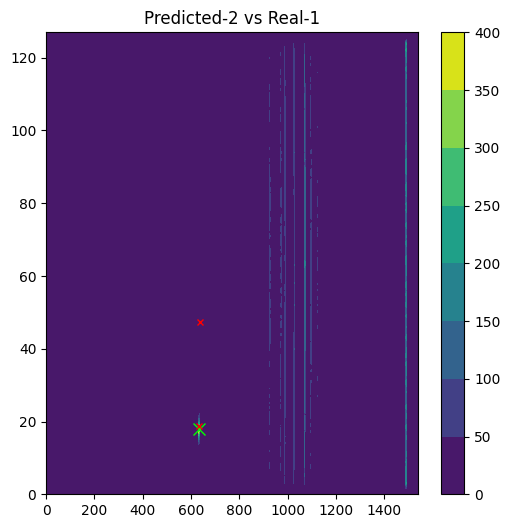

{'boxes': tensor([[211.8514,   4.0810, 224.8065,  13.9376],
        [213.1124,  82.3239, 223.7204,  92.0253]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9852, 0.7308], device='cuda:0')}
prediction=tensor([211.8514,   4.0810, 224.8065,  13.9376]) score=0.9852200746536255
Prediction coordinate x=218.32896423339844 y=9.009278297424316
prediction=tensor([213.1124,  82.3239, 223.7204,  92.0253]) score=0.7308157086372375
Prediction coordinate x=218.41639709472656 y=87.17460632324219


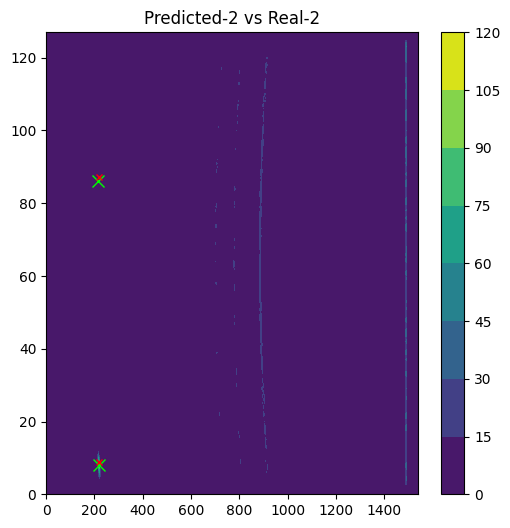

{'boxes': tensor([[767.7554,  15.9112, 777.0077,  26.1183],
        [554.6993,  29.2384, 559.8571,  39.1692],
        [555.2117,  53.3555, 560.6586,  63.1334]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.9837, 0.0599], device='cuda:0')}
prediction=tensor([767.7554,  15.9112, 777.0077,  26.1183]) score=0.9991728663444519
Prediction coordinate x=772.3815307617188 y=21.014738082885742
prediction=tensor([554.6993,  29.2384, 559.8571,  39.1692]) score=0.9836723208427429
Prediction coordinate x=557.2781982421875 y=34.20378875732422
prediction=tensor([555.2117,  53.3555, 560.6586,  63.1334]) score=0.059895239770412445
----->Ignoring the prediction at x=557.9351196289062 y=58.24446105957031 with score=0.059895239770412445


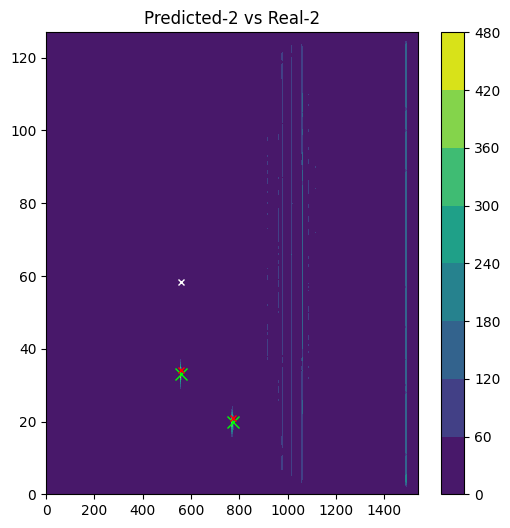

{'boxes': tensor([[ 598.2792,  111.0117,  604.4634,  120.9701],
        [ 596.4995,   31.9941,  602.4733,   42.1774],
        [ 599.9586,   57.9685,  605.3914,   67.9618],
        [ 599.1221,   84.6520,  604.3886,   93.9608],
        [1116.3885,    3.0385, 1124.2092,   12.5150]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9949, 0.9939, 0.9799, 0.1039, 0.0642], device='cuda:0')}
prediction=tensor([598.2792, 111.0117, 604.4634, 120.9701]) score=0.9949377775192261
Prediction coordinate x=601.371337890625 y=115.99089813232422
prediction=tensor([596.4995,  31.9941, 602.4733,  42.1774]) score=0.9938901662826538
Prediction coordinate x=599.4863891601562 y=37.08576965332031
prediction=tensor([599.9586,  57.9685, 605.3914,  67.9618]) score=0.9798847436904907
Prediction coordinate x=602.6749877929688 y=62.96519088745117
prediction=tensor([599.1221,  84.6520, 604.3886,  93.9608]) score=0.10387226194143295
----->Ignoring the prediction at x=601.755371

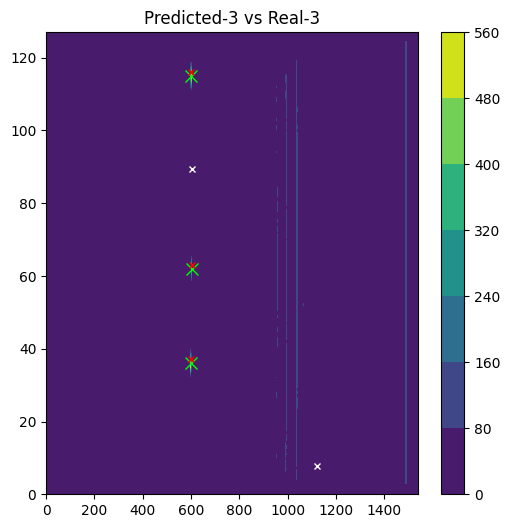

{'boxes': tensor([[ 537.7689,   42.4258,  542.7386,   52.2104],
        [ 534.1834,   18.7931,  538.0318,   28.6319],
        [ 754.4237,   89.0478,  762.6519,   99.1438],
        [ 539.4815,   89.0697,  543.8315,   99.1013],
        [1115.5001,   19.0668, 1123.6104,   29.0053],
        [ 748.4258,   18.9917,  756.7496,   29.1689],
        [ 539.6522,   65.8904,  544.4785,   76.0189],
        [1121.2052,   89.0767, 1128.7441,   98.9184],
        [ 753.7217,   53.8660,  762.2839,   63.8036]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.9984, 0.9952, 0.9921, 0.9908, 0.9873, 0.9664, 0.9231, 0.8696],
       device='cuda:0')}
prediction=tensor([537.7689,  42.4258, 542.7386,  52.2104]) score=0.9990992546081543
Prediction coordinate x=540.2537841796875 y=47.318084716796875
prediction=tensor([534.1834,  18.7931, 538.0318,  28.6319]) score=0.9983850717544556
Prediction coordinate x=536.1076049804688 y=23.712528228759766
predictio

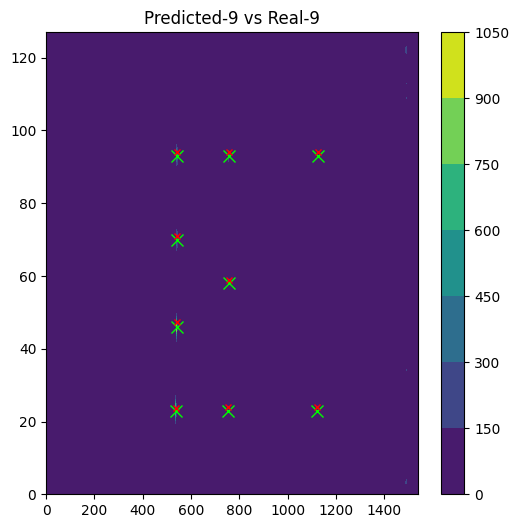

{'boxes': tensor([[4.9895e+02, 1.9132e-01, 5.0577e+02, 6.7628e+00]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}
prediction=tensor([4.9895e+02, 1.9132e-01, 5.0577e+02, 6.7628e+00]) score=0.9977796673774719
Prediction coordinate x=502.35931396484375 y=3.4770798683166504


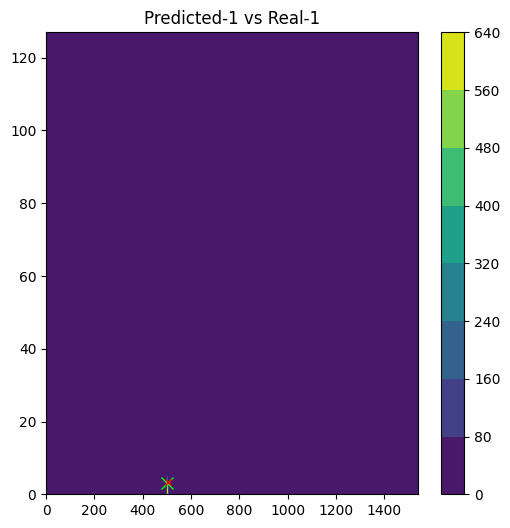

{'boxes': tensor([[580.4352,  74.8640, 586.4784,  84.9959],
        [572.5126,   0.0000, 578.2017,   8.8854],
        [580.0066,  50.0375, 586.0725,  60.2117],
        [576.7580,  25.1371, 582.2720,  34.9072]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9935, 0.8794, 0.7986, 0.0627], device='cuda:0')}
prediction=tensor([580.4352,  74.8640, 586.4784,  84.9959]) score=0.9935386776924133
Prediction coordinate x=583.456787109375 y=79.929931640625
prediction=tensor([572.5126,   0.0000, 578.2017,   8.8854]) score=0.8793718814849854
Prediction coordinate x=575.357177734375 y=4.442697525024414
prediction=tensor([580.0066,  50.0375, 586.0725,  60.2117]) score=0.7986031174659729
Prediction coordinate x=583.03955078125 y=55.12457275390625
prediction=tensor([576.7580,  25.1371, 582.2720,  34.9072]) score=0.06272459030151367
----->Ignoring the prediction at x=579.5150146484375 y=30.022130966186523 with score=0.06272459030151367


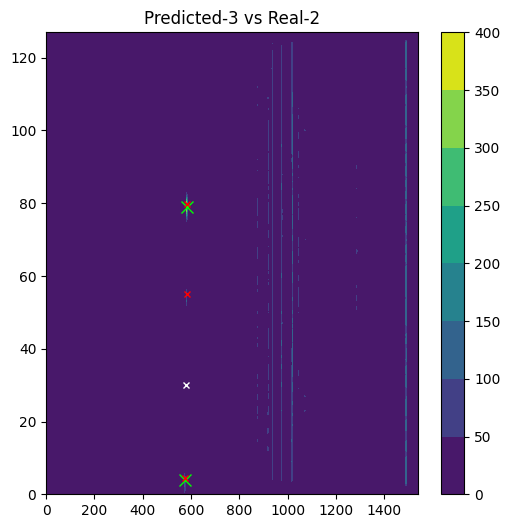

{'boxes': tensor([[357.6740, 123.0891, 362.9794, 128.0000],
        [574.3605, 115.0421, 584.4979, 124.9832],
        [368.7727,   3.7878, 374.1276,  13.8885],
        [584.4703,  12.0404, 593.1063,  21.9352],
        [369.9116,  20.3805, 374.8409,  30.8011]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.9942, 0.9111, 0.9040, 0.7647], device='cuda:0')}
prediction=tensor([357.6740, 123.0891, 362.9794, 128.0000]) score=0.99850994348526
Prediction coordinate x=360.32672119140625 y=125.54457092285156
prediction=tensor([574.3605, 115.0421, 584.4979, 124.9832]) score=0.9942442774772644
Prediction coordinate x=579.42919921875 y=120.01264953613281
prediction=tensor([368.7727,   3.7878, 374.1276,  13.8885]) score=0.9111166596412659
Prediction coordinate x=371.45013427734375 y=8.838149070739746
prediction=tensor([584.4703,  12.0404, 593.1063,  21.9352]) score=0.9039778709411621
Prediction coordinate x=588.788330078125 y=16.98782730102539
predi

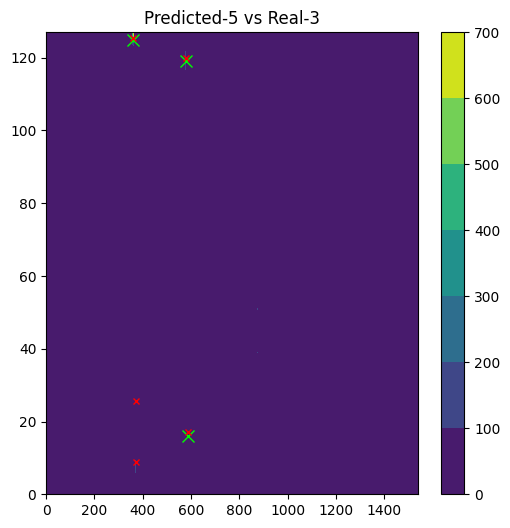

In [41]:
r_model.eval()
probe = 0
for img, target in data_loader_test:
    imgs = list(img)
    targets = list(target)
    with tc.no_grad():
        for img, target in zip(imgs, targets):
            prediction = r_model([img.to(device)])[0]
            nms_prediction = apply_nms(prediction, iou_thresh=0.001)
            print(nms_prediction)
            plot_frame_detections(img[0,:,:], target['boxes'], nms_prediction, score_threshold = 0.5)
            probe += 1

    if probe >= 50:
        break